Data fields

1. Most of the fields are self-explanatory. The following are descriptions for those that aren't.

    - Id - an Id that represents a (Store, Date) duple within the test set
    
    - Store - a unique Id for each store
    - Sales - the turnover for any given day (this is what you are predicting)
    - Customers - the number of customers on a given day
    - Open - an indicator for whether the store was open: 0 = closed, 1 = open
    - StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on - public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
    - SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
    - StoreType - differentiates between 4 different store models: a, b, c, d
    - Assortment - describes an assortment level: a = basic, b = extra, c = extended
    - CompetitionDistance - distance in meters to the nearest competitor store
    - CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
    - Promo - indicates whether a store is running a promo on that day
    - Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
    - Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
    - PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means - each round starts in February, May, August, November of any given year for that store


## IMPORTS

In [1]:
import math
import inflection
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import plotly.express as px
import matplotlib.pyplot as plt

from IPython.core.display   import HTML
from scipy                  import stats
from IPython.display        import Image
from boruta                 import BorutaPy

from sklearn.ensemble       import RandomForestRegressor
from sklearn.linear_model   import LinearRegression, Lasso
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics        import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Funções

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 20
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

jupyter_settings()

#Analise Exploratoria de dados
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

#Machine Learning - performace
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])



#Machine Learning - CROSS VALIDATION
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    # inicio e final para validação

    # |----------------------fulldataset------------------------|
    # |--training--|--validation--|
    # |----------training---------|--validation--|
    # |-----------------training-----------------|--validation--|

    #list creator
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, 6)):
        if verbose:
            print('\nKfold Number: {}'.format(k))

        # FILTROS__________________________________________________________________________________________________________
        # filtro c/ range
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days = (k-1)*6*7)

        # filtro do dataset
        training = x_training[x_training['date'] <= validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # TRAIN / TEST______________________________________________________________________________________________________
        # exclusão de colunas

        # training c/ filtro aplicado
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation c/ filtro aplicado
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # MODELOS___________________________________________________________________________________________________________

        # linear regression
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performace
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        

        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    result = pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0, 1, 2, 3])
    
    return result.head(1)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
df_sales_raw = pd.read_csv('train.csv', low_memory=False)
df_stores_raw = pd.read_csv('store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_stores_raw, how='left', on='Store') 

In [4]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
38347,438,6,2015-06-27,4193,421,1,0,0,0,d,c,1110.0,NaN,NaN,1,40.0,2012.0,"Jan,Apr,Jul,Oct"


# **1 ANALISE DESCRITIVA DOS DADOS**

In [5]:
df1 = df_raw.copy()

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1 RENOMEANDO COLUNAS

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

#função p/ transformar os nomes em separados por underline
snakecase = lambda x: inflection.underscore(x).lower()

#nova lista trocando o nome old pelo new
cols_new = list(map(snakecase, cols_old))

#rename old columns
df1.columns = cols_new

1 - DIMENSÃO DADOS

In [8]:
print('number of rows: {}'.format(df1.shape[0]))
print('number of cols: {}'.format(df1.shape[1]))

number of rows: 1017209
number of cols: 18


2 - TIPO DE DADOS

In [9]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [10]:
#transformando date
df1['date'] = pd.to_datetime(df1['date'])

3 - CHECK NaN

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 2 TRATANDO VALORES NULOS

In [12]:
df1['competition_distance'].max()

75860.0

In [13]:
#competiton_distance
#20000 - corresponde a um valor muito maior queo maximo, apenas para servir de outlier
df1['competition_distance'] = df1['competition_distance'].apply (lambda x: 200000.0 if math.isnan(x)
                                                                                    else x)

#competition_open_since_month
#extract month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month'])
                                                                          else x['competition_open_since_month'], axis=1)

#competition_open_since_year
#extract year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year'])
                                                                        else x['competition_open_since_year'], axis=1)

#promo2_since_week
#extract year
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week'])
                                                              else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year'])
                                                              else x['promo2_since_year'], axis=1)

In [14]:
#promo_interval
month_map = {1: 'Jan', 2: 'Fev',3: 'Mar',4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Sep',10: 'Oct',11: 'Nov',12: 'Dec'}

#substituindo nulos por '0'
df1['promo_interval'].fillna(0,inplace=True)

#criando novas colunas p/ numero de mes ser substituido por letra
df1['month_map'] = df1['date'].dt.month.map(month_map)

#nova coluna com condições
#CONDIÇÕES:
#0 se o valor já for zero
#1 se existir (month_map) no (promo_interval)
#0 se não existir (month_map) no (promo_interval)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply (lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [15]:
df1.isnull().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 3 ALTERANDO TIPO DE DADOS

In [16]:
#change types
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

#int32 para int64
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 4 ESTATÍSTICA DESCRITIVA

In [17]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [18]:
m = num_attributes.agg(['min', 'max', 'ptp', 'mean', 'median', 'std', 'skew', 'kurtosis']).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [19]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908651,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997391,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.926175,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411734,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485759,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.652996,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311087,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515593,-7.235657,124.071304


C:\Users\Cliente\AppData\Local\Temp\ipykernel_12744\710812770.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['sales'])


<Axes: xlabel='sales', ylabel='Density'>

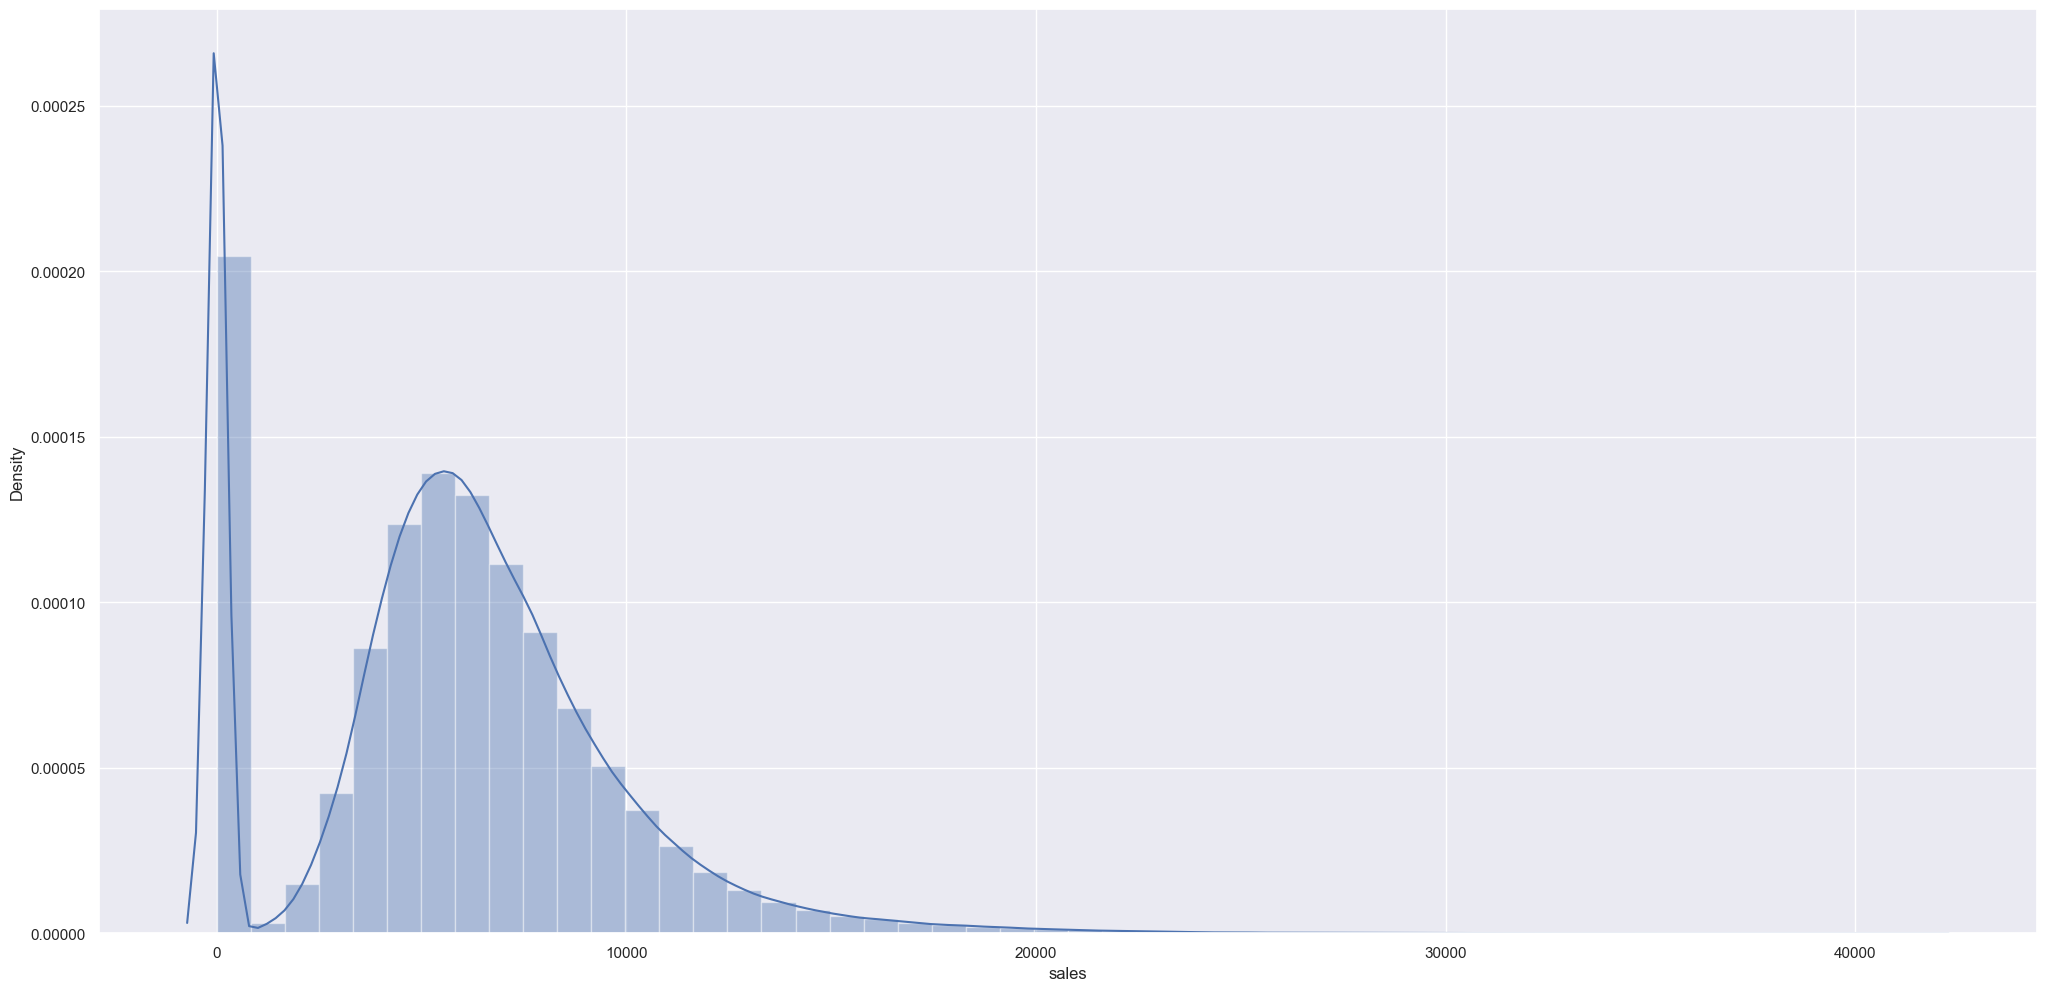

In [20]:
sns.distplot(df1['sales'])

## 5 ATRIBUTOS CATEGORICOS

In [21]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

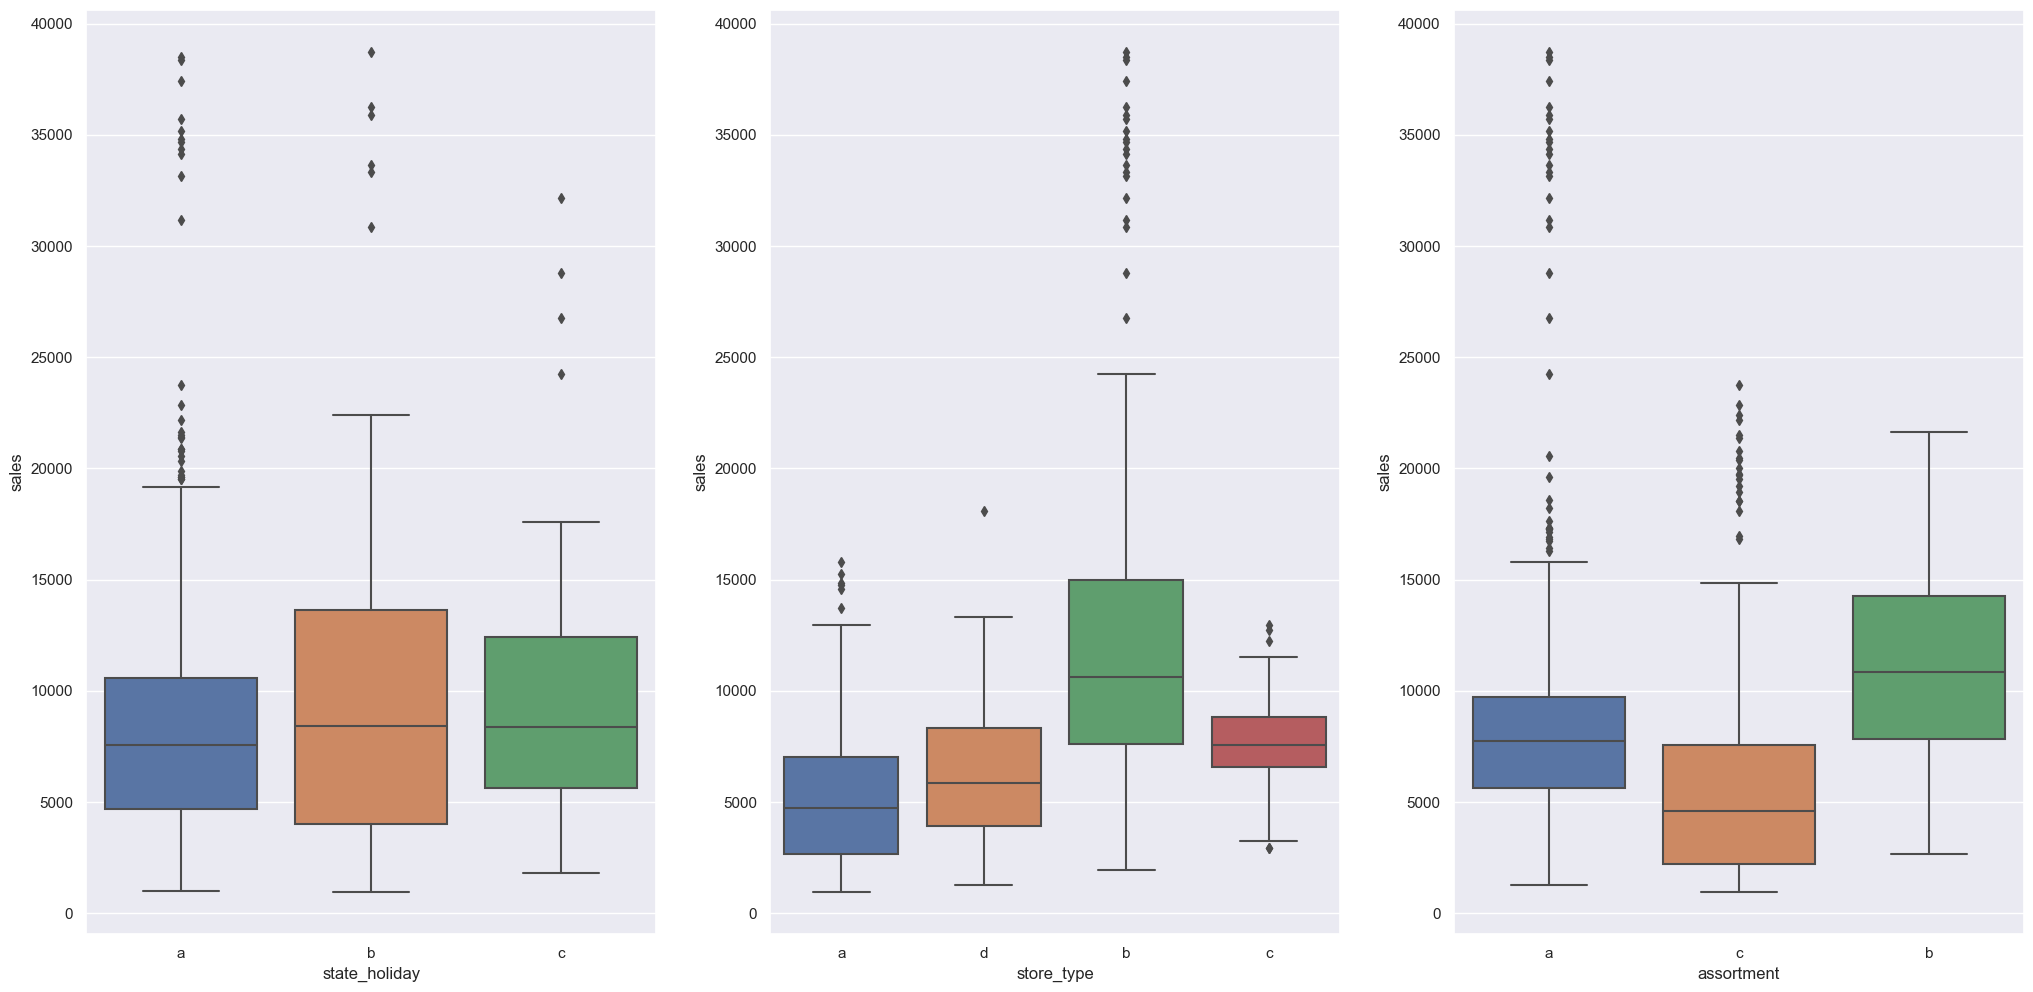

In [22]:
#condições
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

#1 subplot
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday' ,y='sales', data=aux1)

#2 subplot
plt.subplot(1, 3, 2)
sns.boxplot(x='store_type' ,y='sales', data=aux1)

#3 subplot
plt.subplot(1, 3, 3)
sns.boxplot(x='assortment' ,y='sales', data=aux1)

# **2 FEATURE ENGINEERRING**

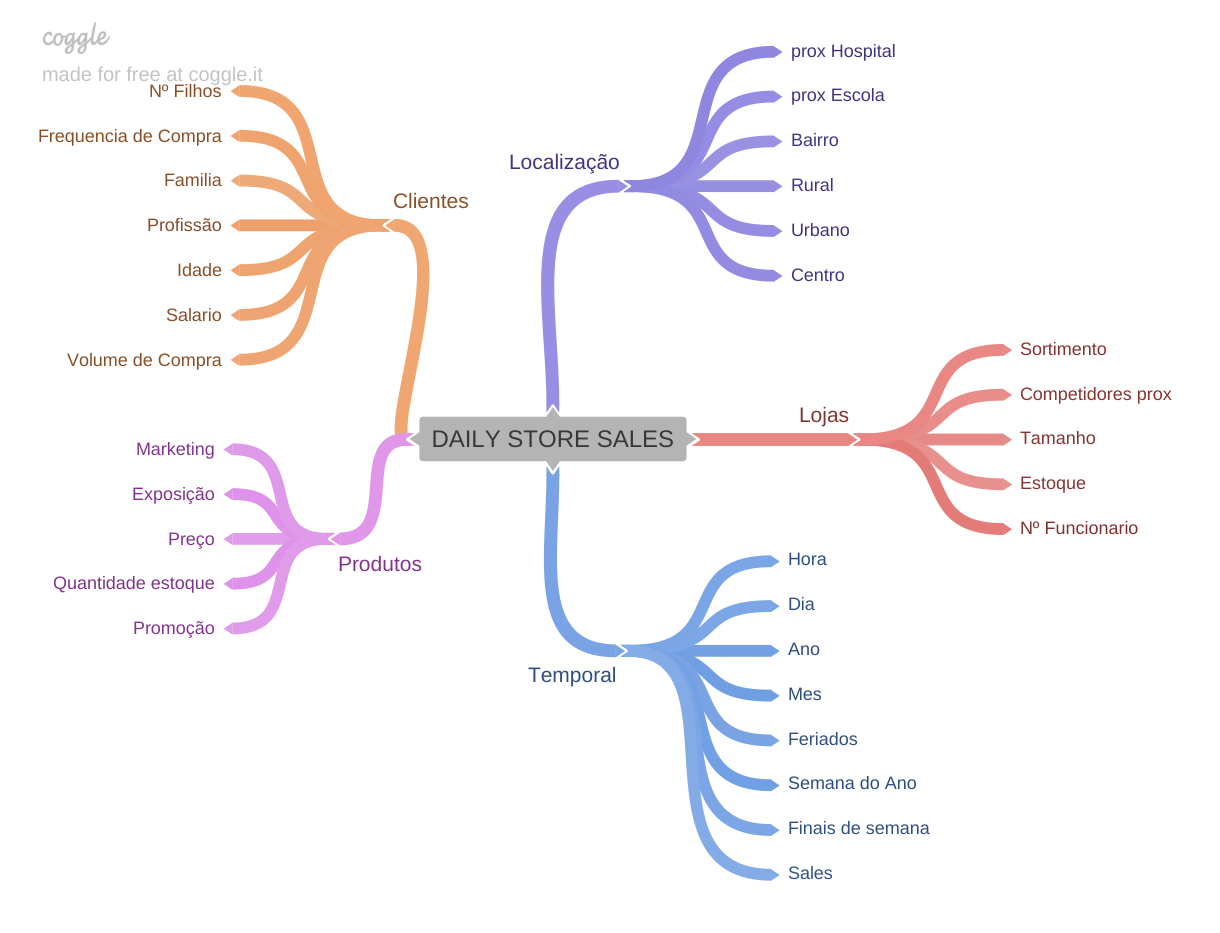

In [23]:
Image('img\mind_map_ross.png')

## 2.1 CRIAÇÃO DE HIPOTESES

### HIPOTESES LOJA

**1.** Lojas com maior numero de funcionarios deveriam vender mais

**2.** Lojas com maior estoque deveriam vender mais

**3.** Lojas com maior porte deveriam vender mais

**4.** Lojas com menor porte deveriam vender menos

**5.** Lojas com maior sortimento deveriam vender mais

**6.** Lojas com competidor mais proximo deveriam vender menos

**7.** Lojas com competidores à mais tempo, deveriam vender mais

### HIPOTESES PRODUTO

**1.** Loja que investe mais em marketing deveria vender mais

**2.** Lojas que expoe mais os produtos na vitrine deveriam vender mais

**3.** Lojas que tem preços menores nos produtos deveriam vender mais

**4.** Lojas que tem preços menores por mais tempo, deveriam vender mais

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais

**6.** Lojas com mais dias de promoção deveriam vender mais

**7.** Lojas com mais promoções consecutivas deveriam vender mais

### HIPOTESES TEMPO

**1.** Lojas abertas durante feriado de natal, deveriam vender mais

**2.** Lojas deveriam vender mais ao longo dos anos

**3.** Lojas deveriam vender mais no segundo semestre

**4.** Lojas deveriam vender mais depois de dia 10 de cada mes

**5.** Lojas deveriam vender menos aos finais de semana

**6.** Lojas deveriam vender menos durante feriados escolares

### LISTA FINAL DE HIPOTESES
 - Priorização de hipoteses
 - Existem dados suficientes para realizar a resposta dessa hipotese?

**1.** Lojas com maior sortimento deveriam vender mais

**2.** Lojas com competidor mais proximo deveriam vender menos

**3.** Lojas com competidores à mais tempo, deveriam vender mais

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais

**5.** Lojas com mais dias de promoção deveriam vender mais

**6.** Lojas com mais promoções consecutivas deveriam vender mais

**7.** Lojas abertas durante feriado de natal, deveriam vender mais

**8.** Lojas deveriam vender mais ao longo dos anos

**9.** Lojas deveriam vender mais no segundo semestre

**10**. Lojas deveriam vender mais depois de dia 10 de cada mes

**11**. Lojas deveriam vender menos aos finais de semana

**12**. Lojas deveriam vender menos durante feriados escolares



## 2.2 FEATURE ENGINEERING

In [24]:
data = df1.copy()

In [25]:
# year
data['year'] = data['date'].dt.year

# month
data['month'] = data['date'].dt.month

# day
data['day'] = data['date'].dt.day

# week of year
data['week_of_year'] = data['date'].dt.strftime('%U')

# year week
data['year_week'] = data['date'].dt.strftime('%Y-%W')

# competition since
data['competition_since'] = data.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
data['competition_time_month'] = ((data['date'] - data['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo since
data['promo_since'] = data['promo2_since_year'].astype(str) + '-' + data['promo2_since_week'].astype(str)
data['promo_since'] = data['promo_since'].apply(lambda x:datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
data['promo_time_week'] = ((data['date'] - data['promo_since'])/7).apply(lambda x: x.days).astype(int)


# assortment
data['assortment'] = data['assortment'].apply(lambda x: 'basic' if x == 'a'
                                                   else 'extra' if x == 'b' 
                                                   else 'extended')

# state holiday
data['state_holiday'] = data['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a'
                                                   else 'easter_holiday' if x == 'b'
                                                   else 'christmas' if x == 'c'
                                                   else 'regular_day')


## 2.3 FILTRAGEM DE VARIAVEIS

In [26]:
df2 = data.copy()

### Filtragem das Linhas

In [27]:
#filtrando linhas em que a loja estava aberta e as vendas foram maior que 0
df2 = df2[(df2['open'] != 0) &  (df2['sales'] > 0)]

### Seleção das Colunas

In [28]:
#excluindo colunas em que serviram para criação variaveis
#excluindo 'customers', pois não serve para o modelo
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df2 = df2.drop(cols_drop, axis=1)

In [29]:
df2.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# **3 ANALISE EXPLORATORIA DE DADOS**

In [30]:
df3 = df2.copy()

### 11.1 Analise univariada

#### Response variable

C:\Users\Cliente\AppData\Local\Temp\ipykernel_12744\2195709494.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df3['sales'])


<Axes: xlabel='sales', ylabel='Density'>

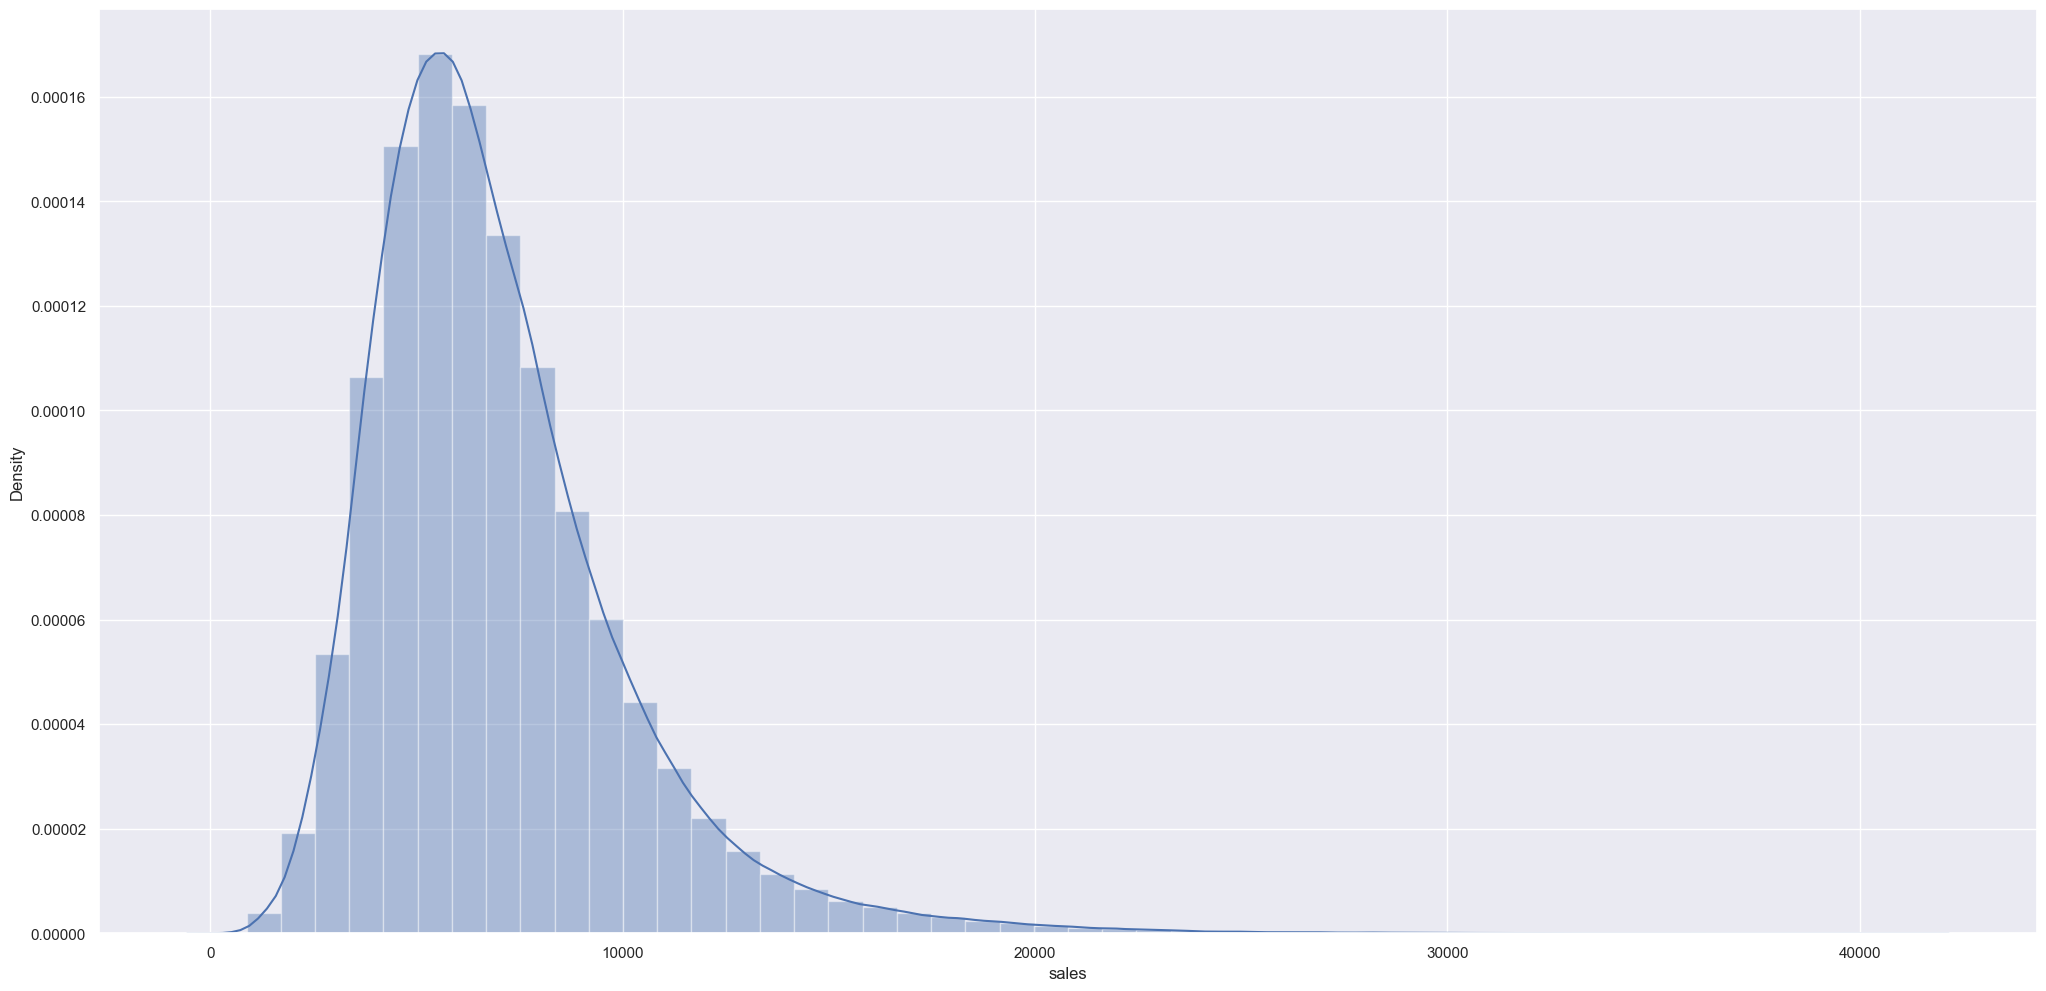

In [31]:
sns.distplot(df3['sales'])

#### Numerical variable

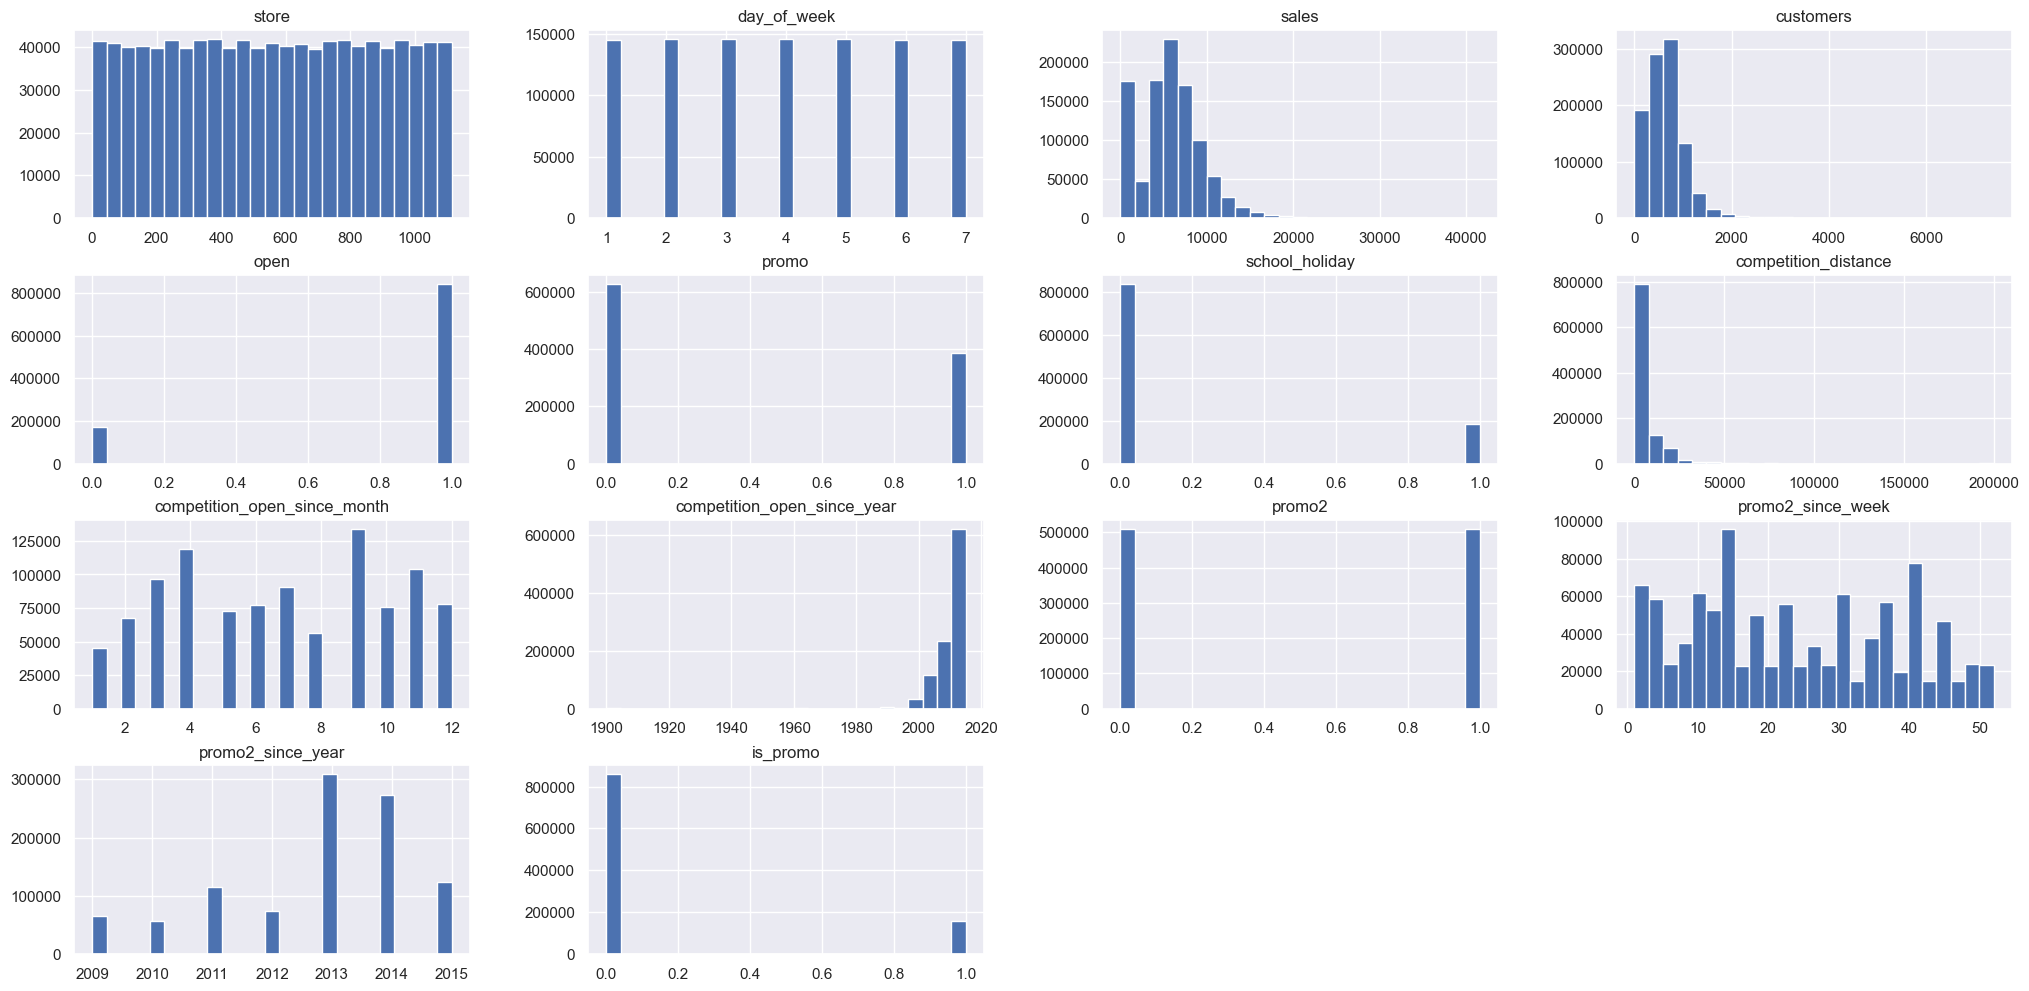

In [32]:
num_attributes.hist(bins=25);

#### Categorical variable

In [33]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


<Axes: xlabel='sales', ylabel='Density'>

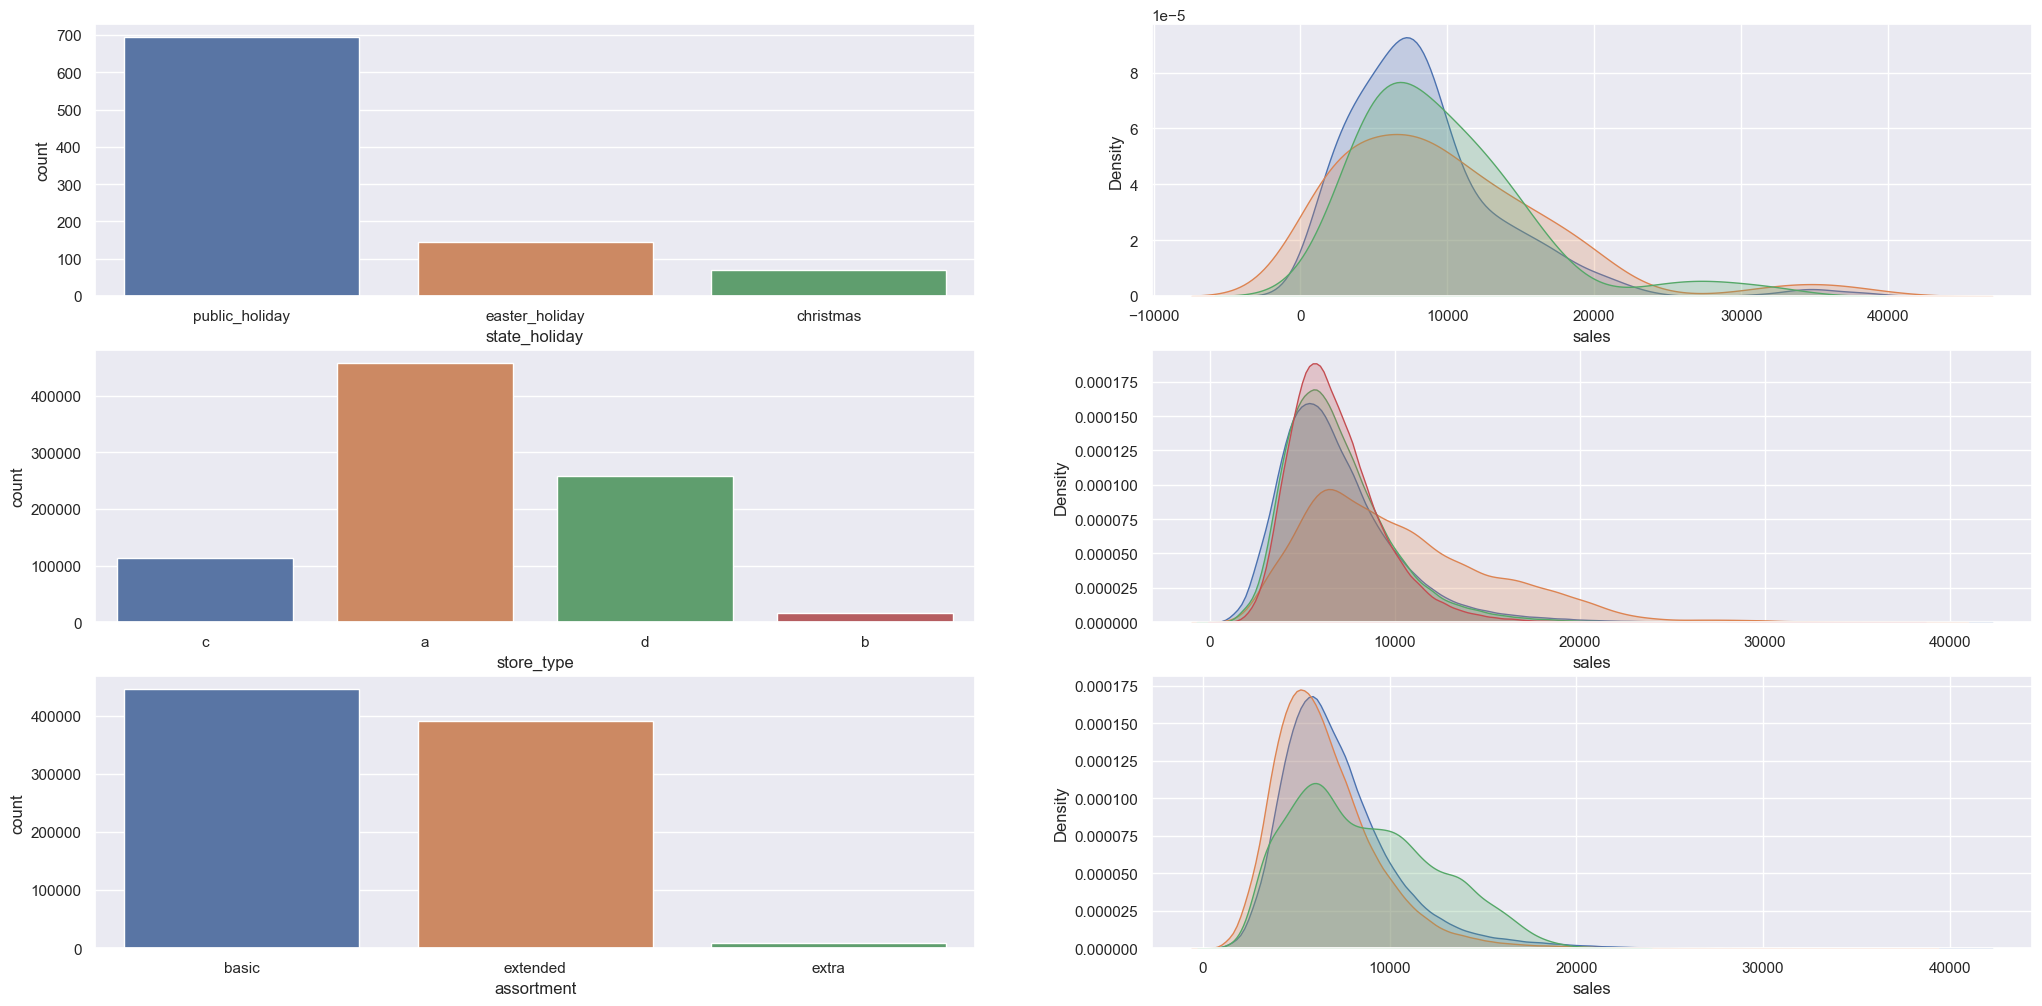

In [34]:
#state_holiday
plt.subplot(3, 2, 1)
a = df3[df3['state_holiday'] != 'regular_day']
sns.countplot(data=a, x= a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df3[df3['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df3[df3['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df3[df3['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

#store_type
plt.subplot(3, 2, 3)
sns.countplot(data=df3, x = df3['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df3[df3['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df3[df3['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df3[df3['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df3[df3['store_type'] == 'd']['sales'], label='d', shade=True)

#assortment
plt.subplot(3, 2, 5)
sns.countplot(data = df3, x = df3['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df3[df3['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df3[df3['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df3[df3['assortment'] == 'extra']['sales'], label='extra', shade=True)

### 11.2 Analise bivariada

#### H.1 Lojas com maior sortimento deveriam vender mais
 - ***FALSA*** Lojas com MAIOR SORTIMENTO vendem MENOS

<Axes: xlabel='year_week'>

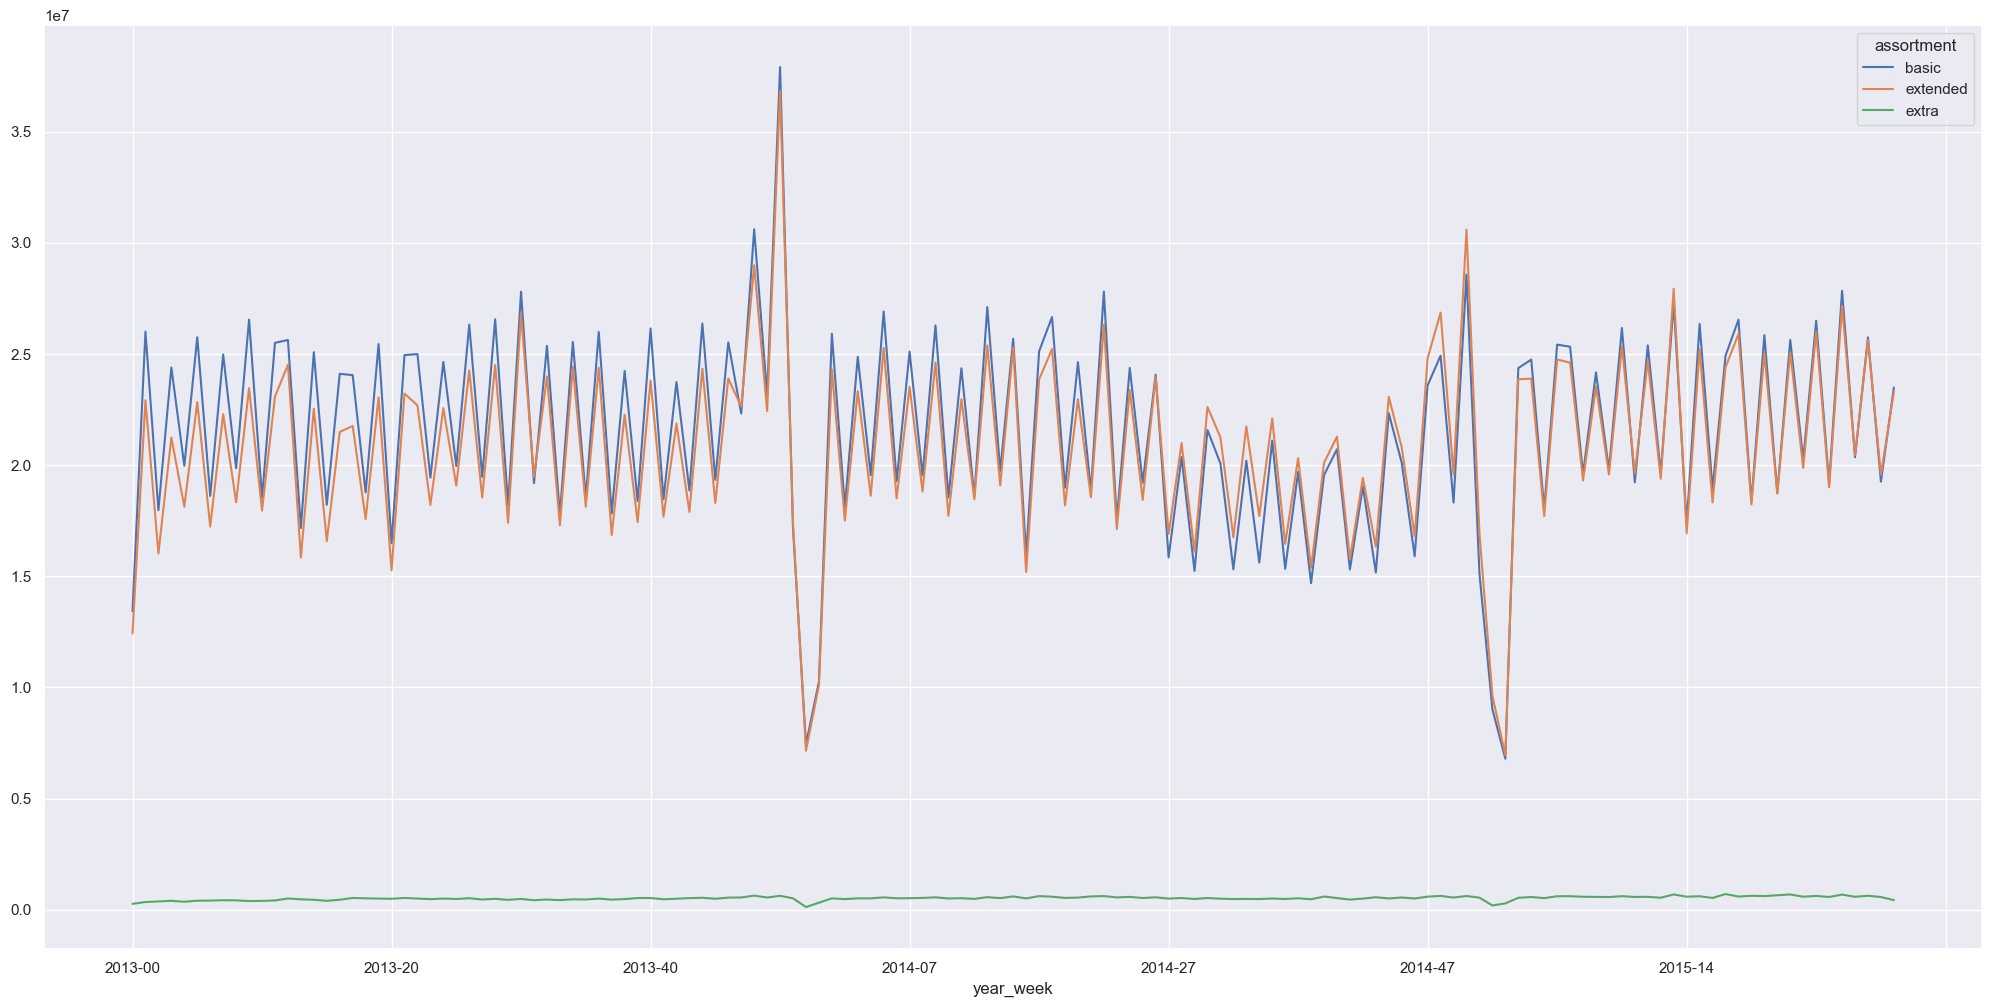

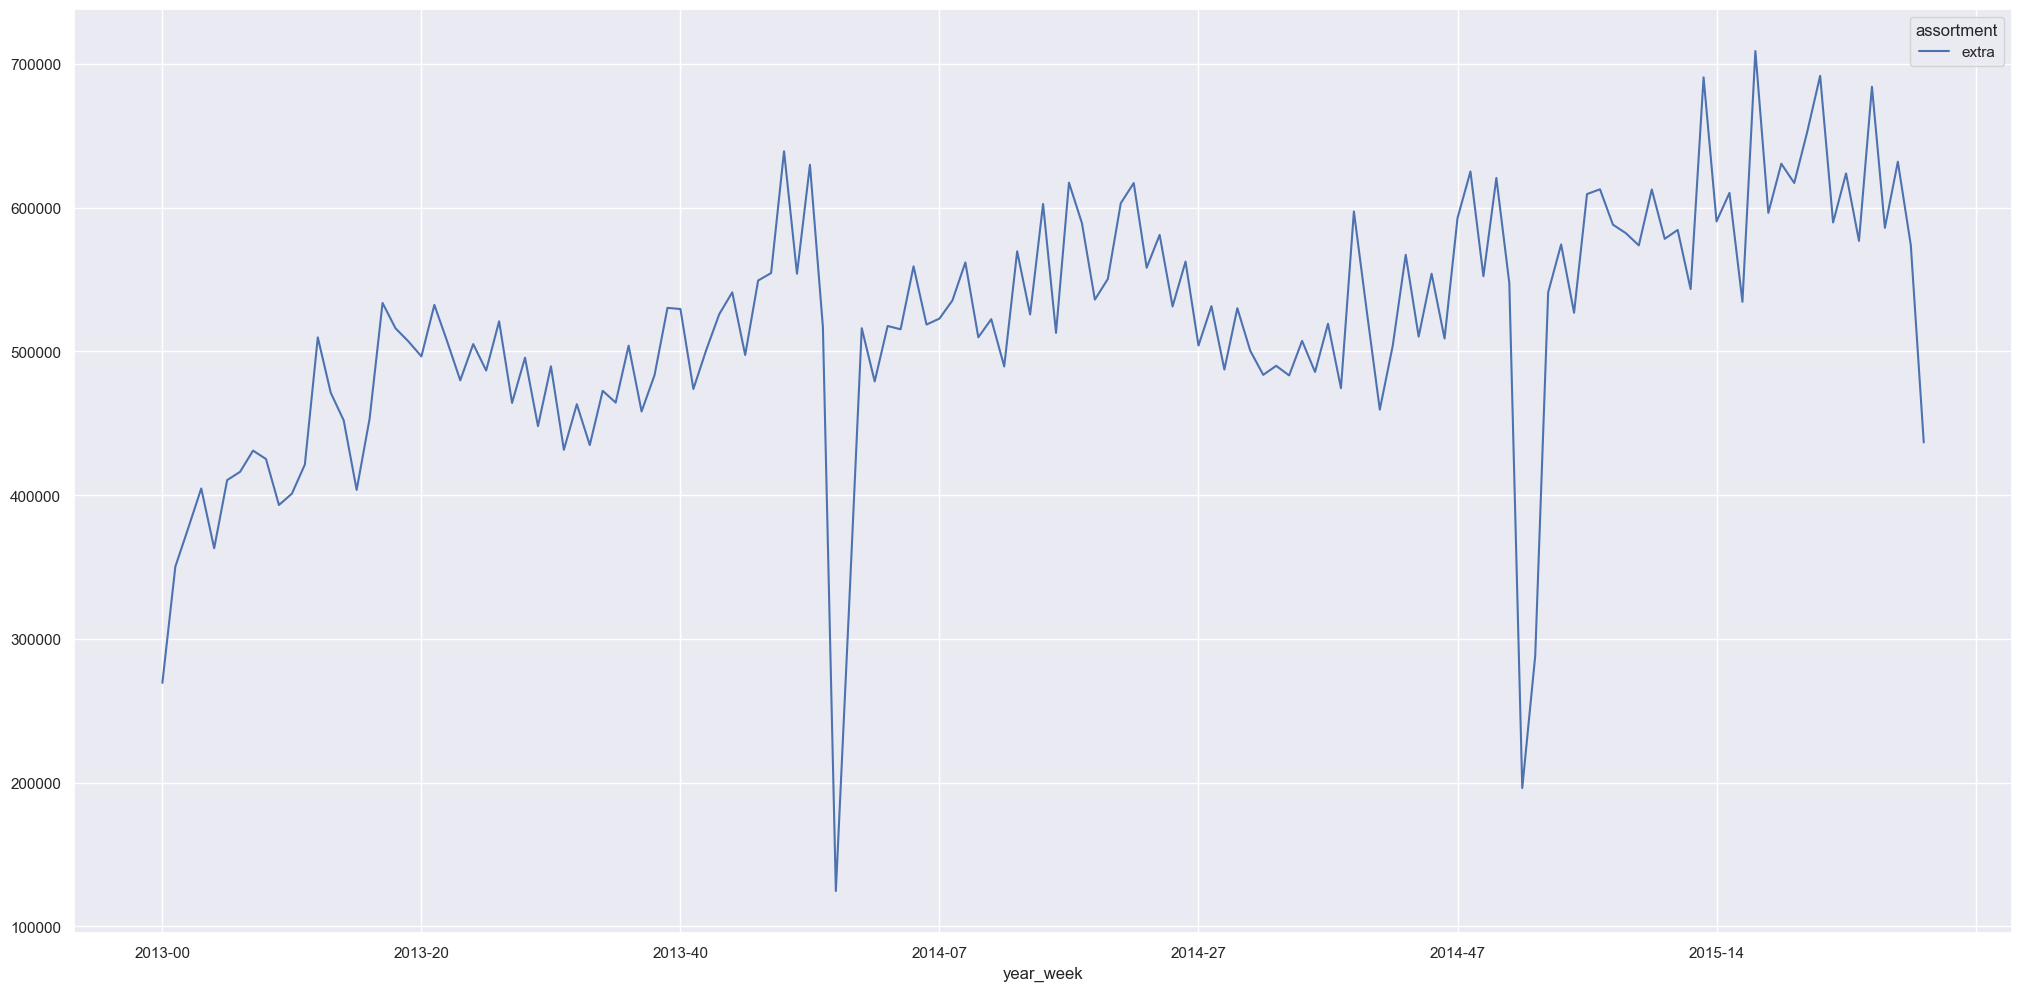

In [35]:
#comportanmento das vendas por tipo de assortment
aux = df3[['assortment', 'sales']].groupby(['assortment']).sum().reset_index()
fig = px.bar(aux, x='assortment', y = 'sales', color='assortment')
fig

#analisando comportamento por semana a semana
aux2 = df3[['year_week' ,'assortment', 'sales']].groupby(['year_week' ,'assortment']).sum().reset_index()
aux2.pivot(index='year_week' ,columns='assortment' ,values='sales').plot()

#analisando comportamento por semana a semana - APENAS DO EXTRA
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week' ,columns='assortment' ,values='sales').plot()

#### H.2 Lojas com competidores mais proximos deveriam vender menos
 - ***FALSA*** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS

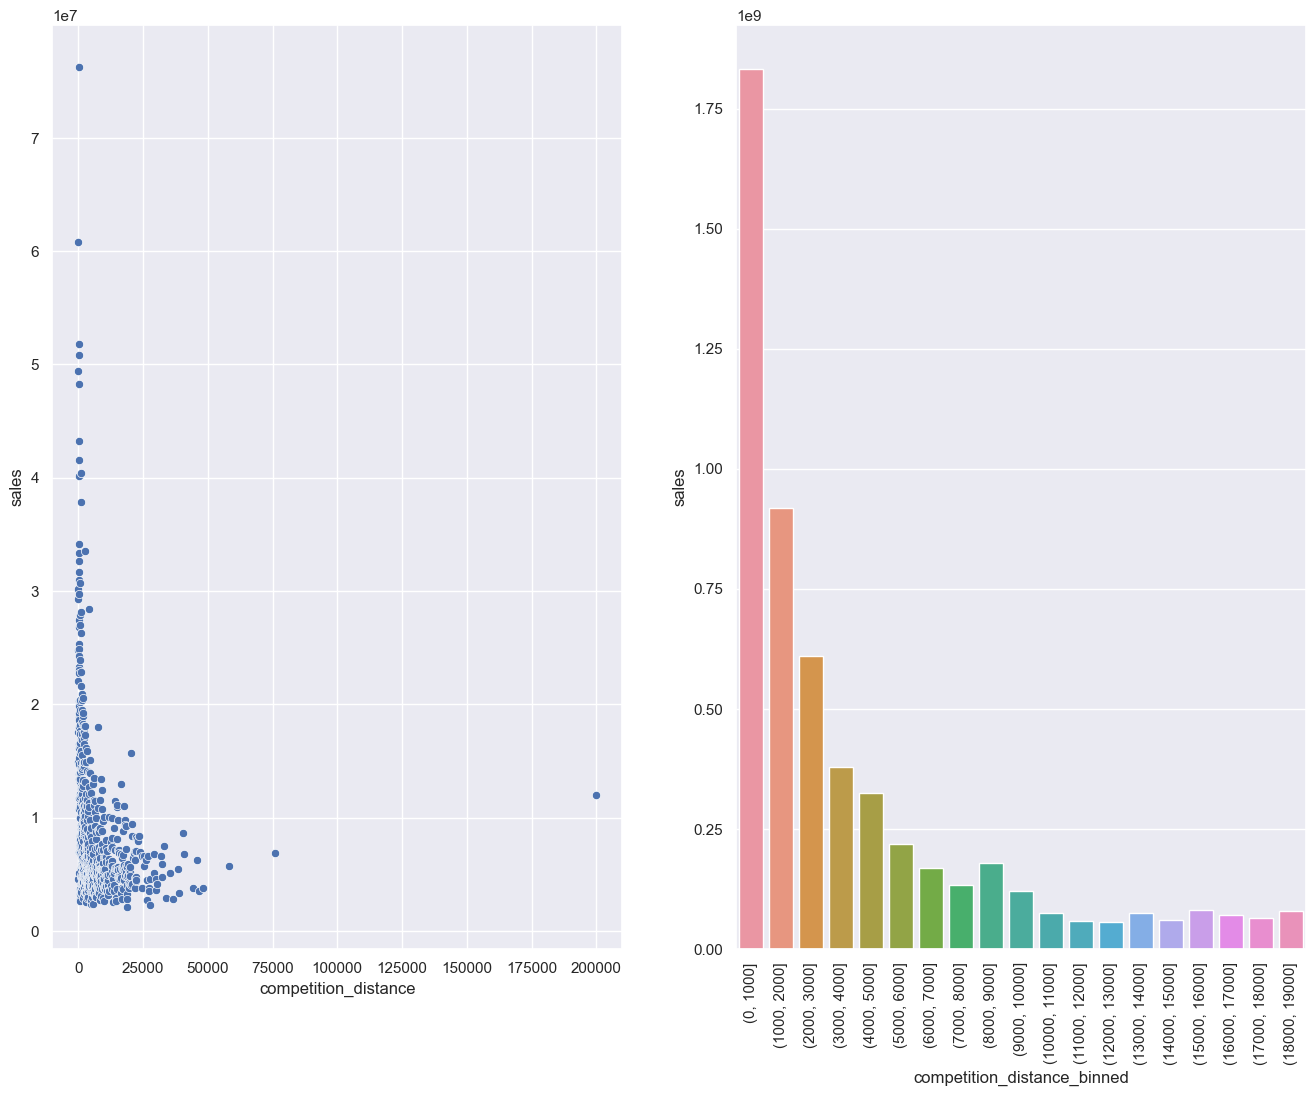

In [36]:
#PRIMEIRA OPÇÃO DE VISUALIZAÇÃO
aux = df3[['competition_distance', 'sales']].groupby(['competition_distance']).sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(data=aux, x='competition_distance', y='sales')

#SEGUNDA OPÇÃO DE VISUALIZAÇÃO
aux = df3[['competition_distance', 'sales']].groupby(['competition_distance']).sum().reset_index()

bins = list(np.arange(0, 20000, 1000))

aux['competition_distance_binned'] = pd.cut(aux['competition_distance'], bins=bins)
aux2 = aux[['competition_distance_binned', 'sales']].groupby(['competition_distance_binned']).sum().reset_index()

plt.subplot(1, 3, 2)
fig = sns.barplot(data=aux2, x='competition_distance_binned', y='sales')
plt.xticks(rotation=90);

#plt.subplot(1, 3, 3)
#sns.heatmap(aux.corr(method='pearson'), annot=True);

#### H.3 Lojas com competidores a mais tempo deveriam vender mais
 - ***FALSA*** Lojas com COMPETIDORES A MAIS TEMPO vendem MENOS

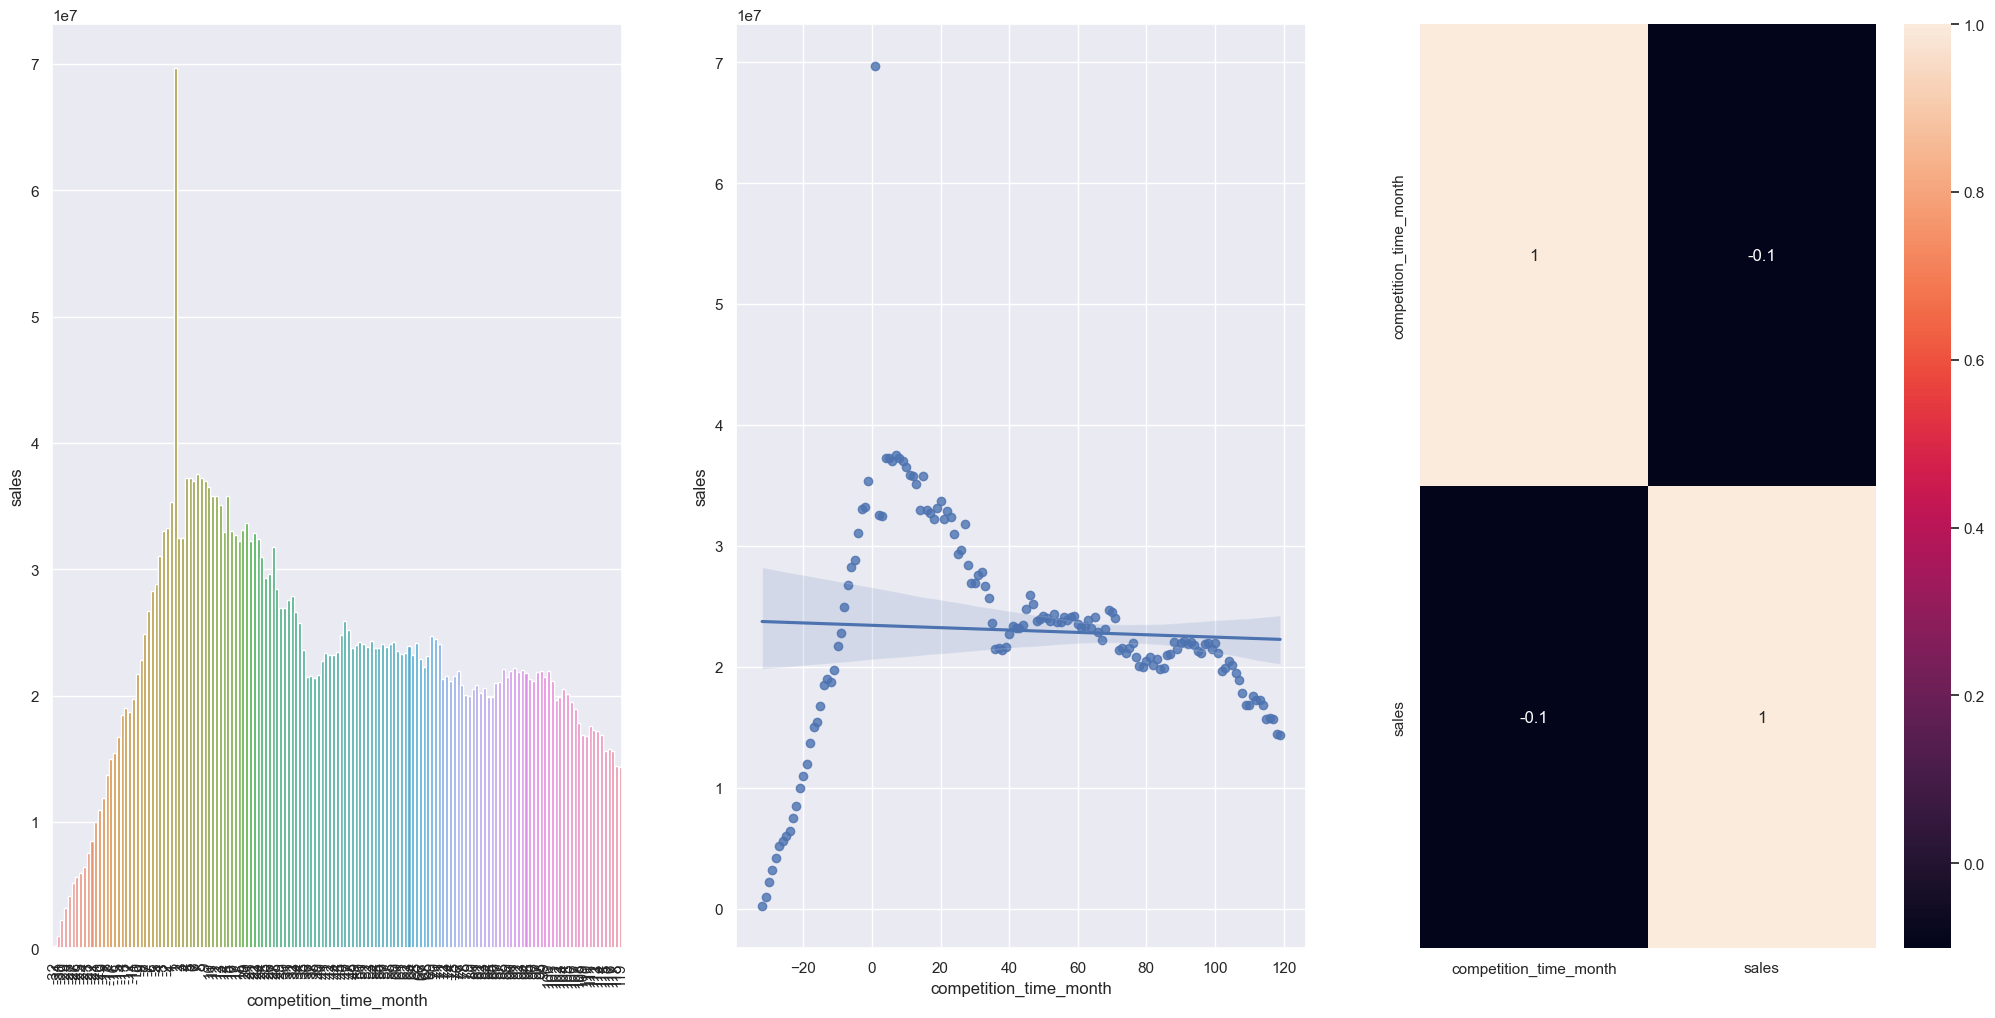

In [37]:
aux = df3[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

plt.subplot(1, 3, 1)
aux2 = aux[(aux['competition_time_month'] < 120) & (aux['competition_time_month'] != 0)]
sns.barplot(data=aux2, x='competition_time_month', y='sales')
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(data=aux2 ,x='competition_time_month', y='sales');

plt.subplot(1, 3, 3)
sns.heatmap(aux.corr(method='pearson'), annot=True);

#### H.4 Lojas com promoções ativas por mais tempo deveriam vender mais
 - ***FALSA*** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo tempo de promo

C:\Users\Cliente\AppData\Local\Temp\ipykernel_12744\858439432.py:6: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



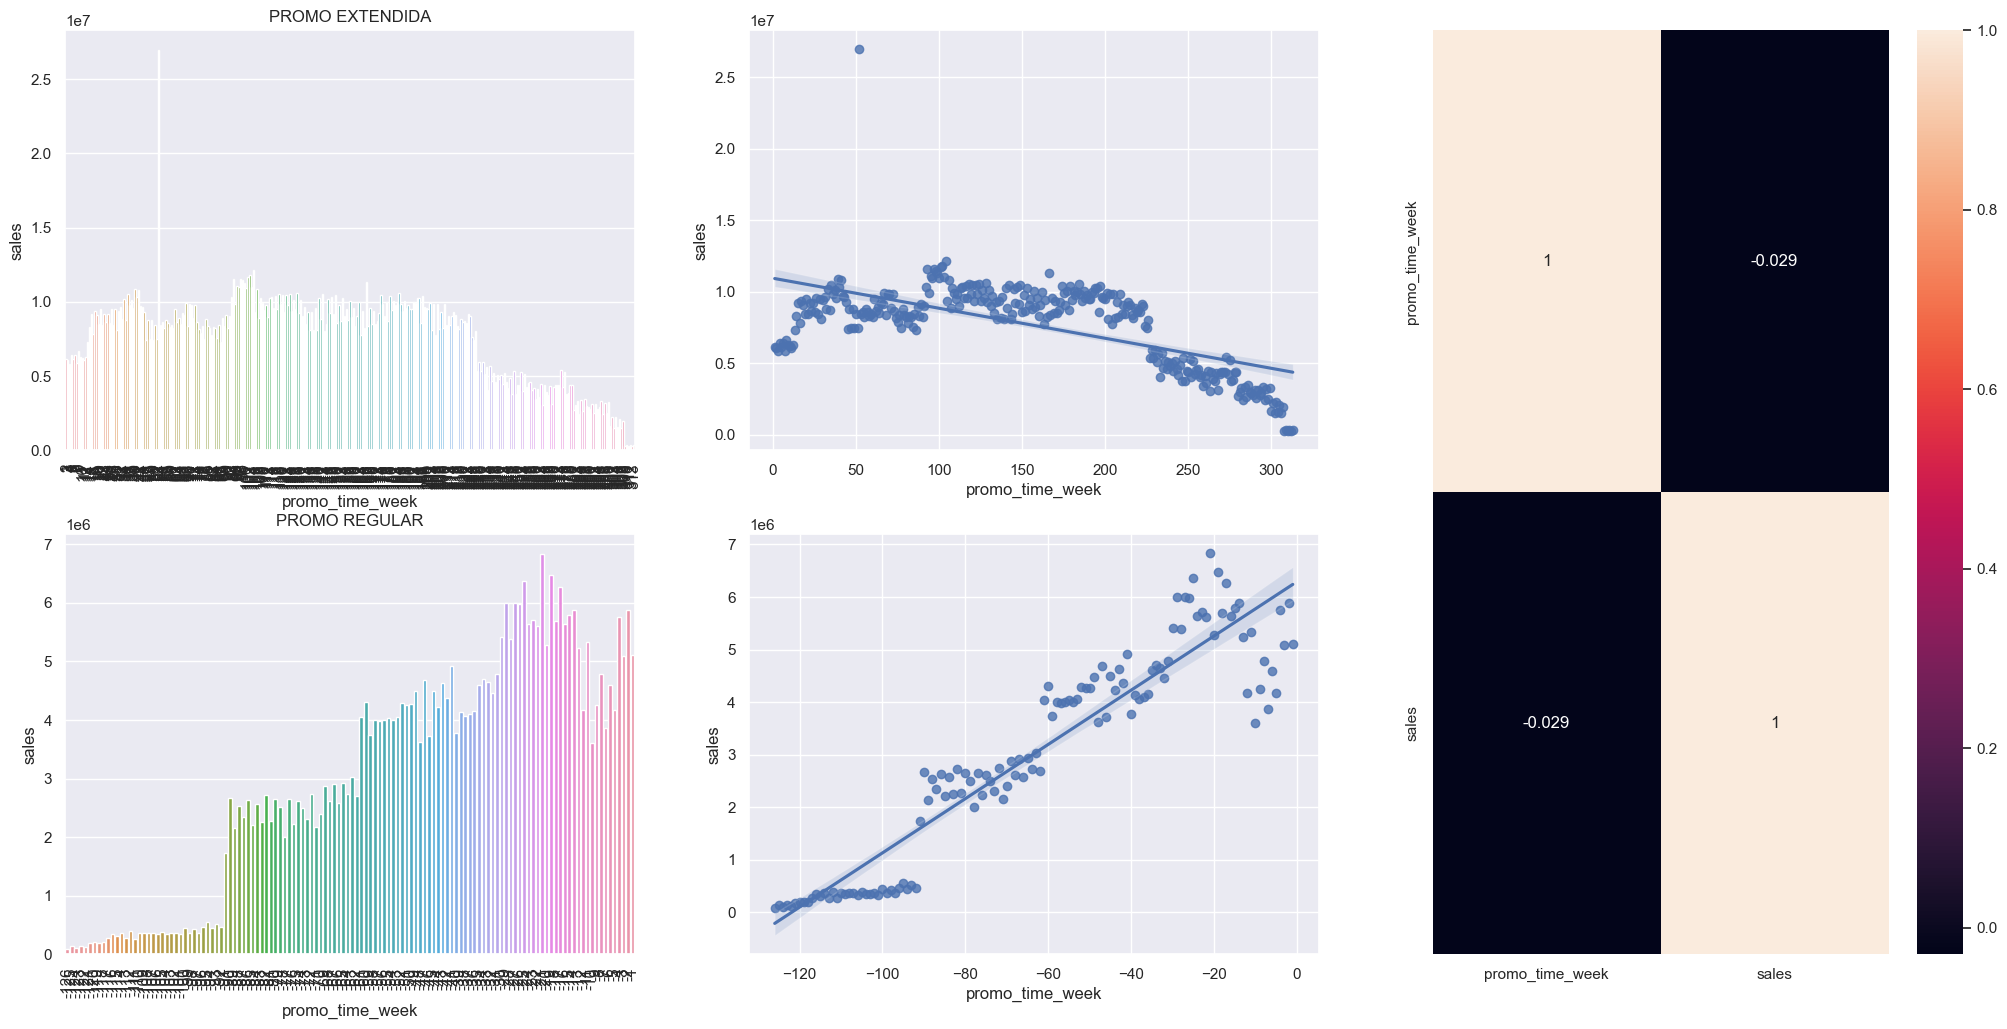

In [38]:
aux = df3[['promo_time_week', 'sales']].groupby(['promo_time_week']).sum().reset_index()
sns.barplot(data=aux, x='promo_time_week', y='sales')

grid = GridSpec(2, 3)
#graficos
plt.subplot(grid[0,0])
aux2 = aux[aux['promo_time_week'] > 0]#promo extendida
sns.barplot(data=aux2, x='promo_time_week', y='sales').set(title='PROMO EXTENDIDA');
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(data=aux2, x='promo_time_week', y='sales');

plt.subplot(grid[1,0])
aux3 = aux[aux['promo_time_week'] < 0]#promo regular
sns.barplot(data=aux3, x='promo_time_week', y='sales').set(title='PROMO REGULAR');
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(data=aux3, x='promo_time_week', y='sales');

#força correlação
plt.subplot(grid[:,2])
sns.heatmap(aux.corr(method='pearson'), annot=True);

#### H.5 Lojas com mais promoções consecutivas deveriam vender mais
 - ***FALSA*** Lojas com mais promoções consecutivas vendem menos

In [39]:
df3[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


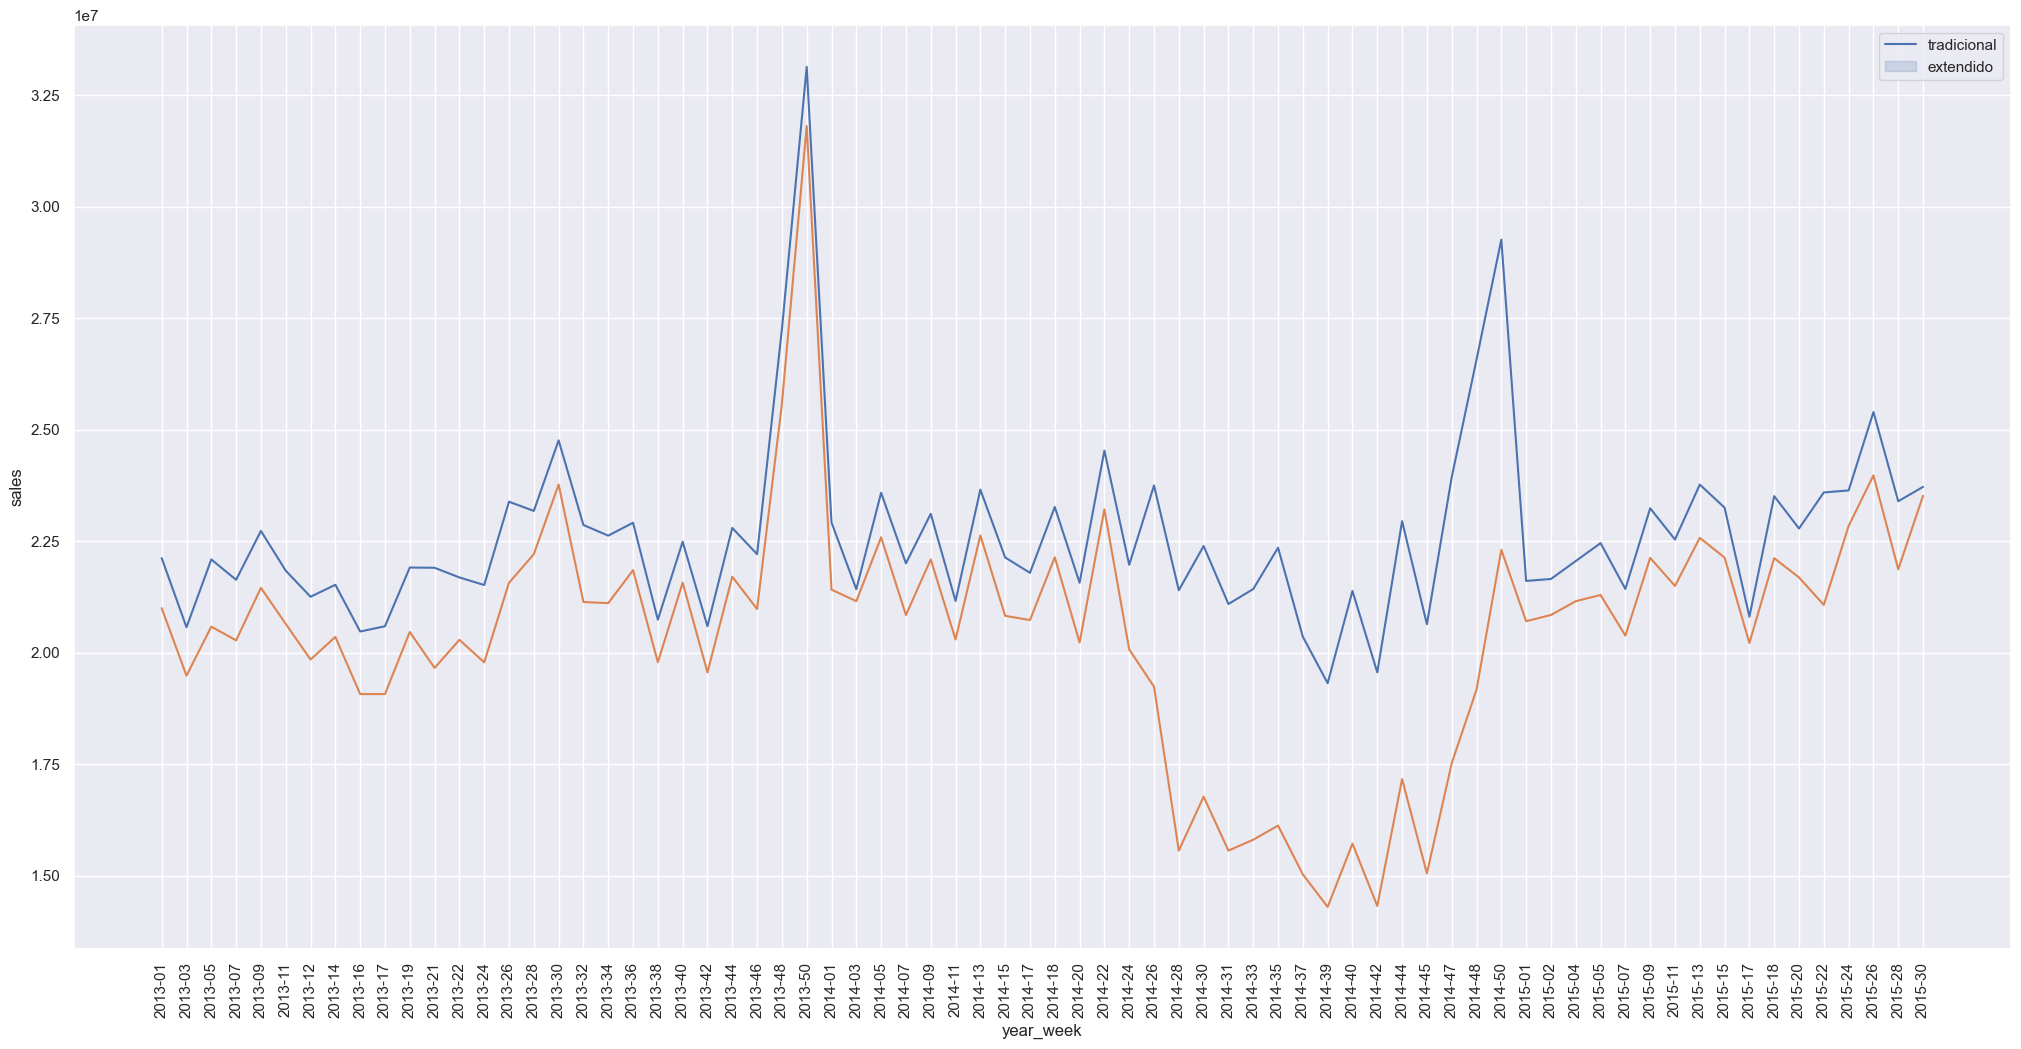

In [40]:
tradicional = df3.loc[(df3['promo'] == 1) & (df3['promo2'] == 0) ,['year_week', 'sales']].groupby('year_week').sum().reset_index()
sns.lineplot(data = tradicional, x='year_week' , y='sales', )


extendido = df3.loc[(df3['promo'] == 1) & (df3['promo2'] == 1) ,['year_week', 'sales']].groupby('year_week').sum().reset_index()
sns.lineplot(data = extendido, x='year_week' , y='sales')

plt.legend(labels = ['tradicional','extendido'])
plt.xticks(rotation=90);

#### H.6 Lojas abertas durante o feriado do natal vendem mais
 - ***FALSA*** Lojas abertas durante o feriado do natal vendem menos

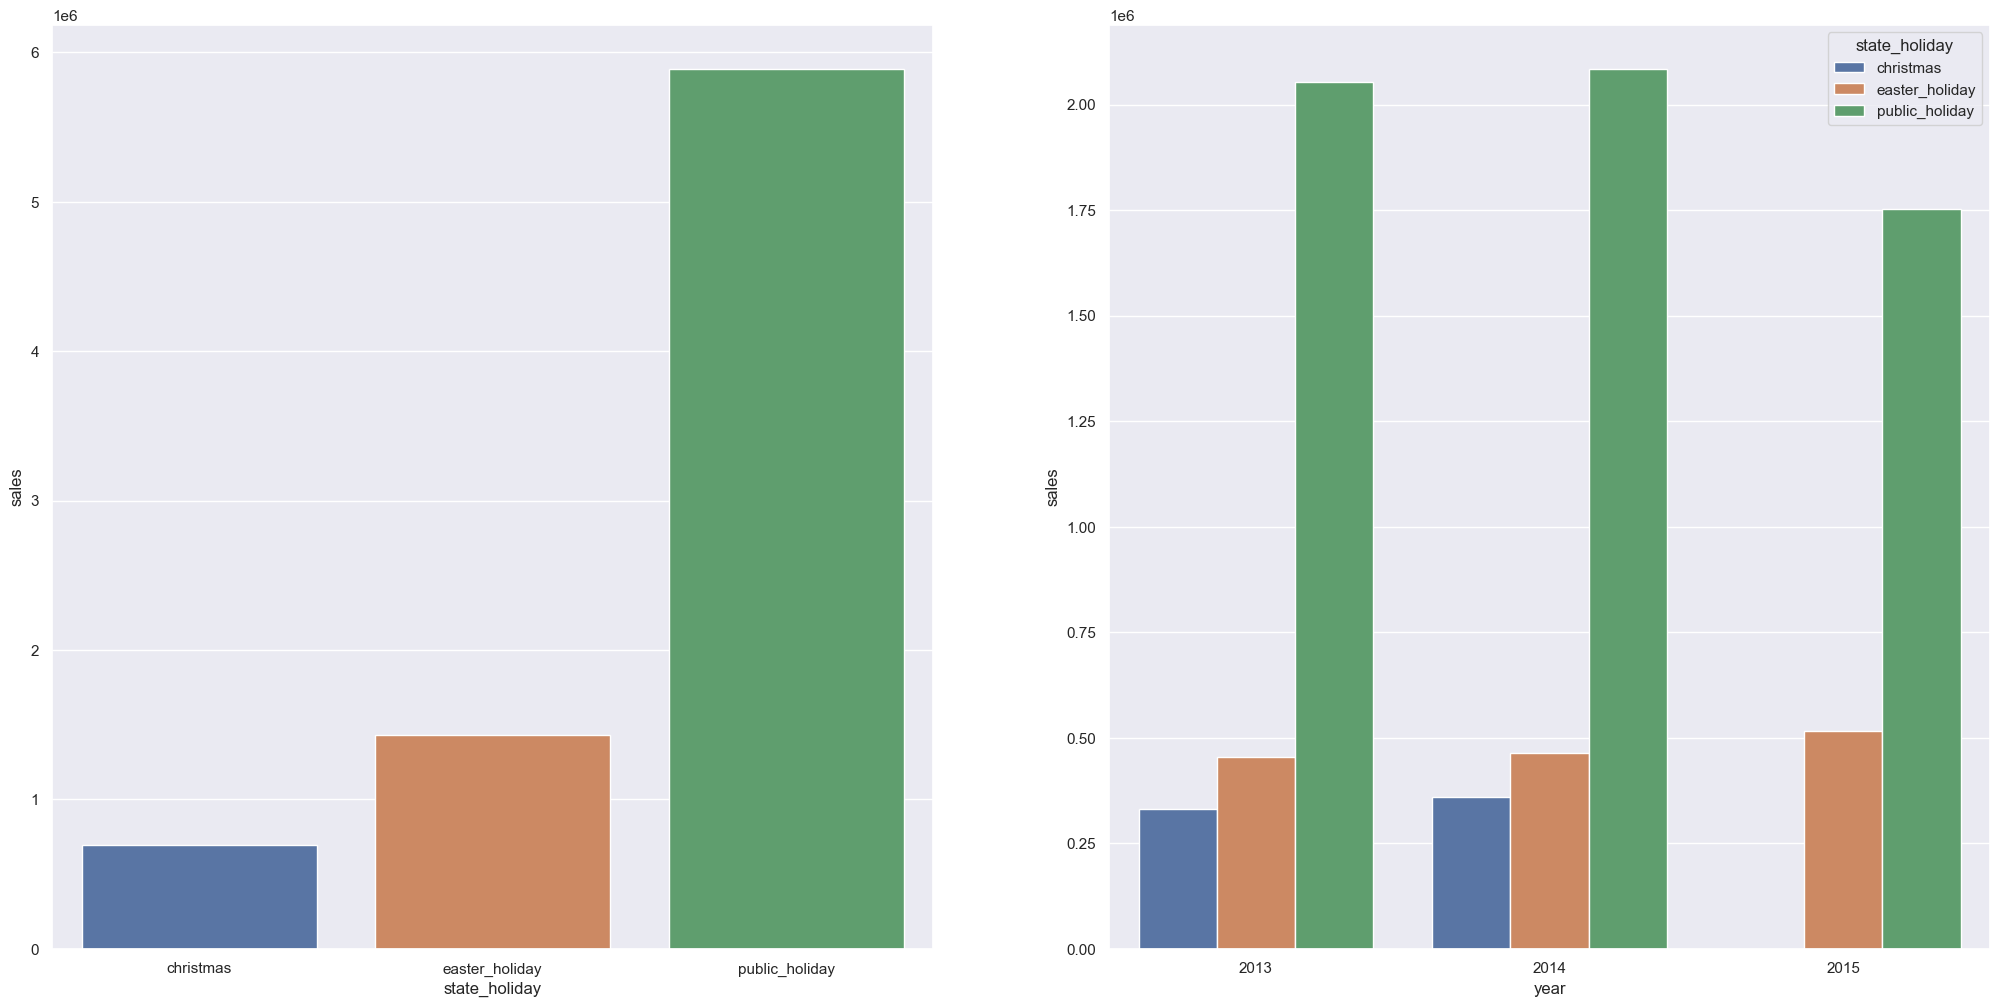

In [41]:
plt.subplot(1, 2, 1)
aux = df3.loc[df3['state_holiday'] != 'regular_day' ,['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(data = aux, x='state_holiday', y='sales');

plt.subplot(1, 2, 2)
aux2 = aux = df3.loc[df3['state_holiday'] != 'regular_day' ,['state_holiday', 'year', 'sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(data = aux2, x='year', y='sales', hue='state_holiday');

In [42]:
#apenas para exemplificar: feriado, tipo de loja e quantas abriram nos respectivos feriados

pd.crosstab(df3['state_holiday'], df3['store_type'])

store_type,a,b,c,d
state_holiday,,,,
christmas,4,66,0,1
easter_holiday,36,100,0,9
public_holiday,236,285,65,108
regular_day,456766,15109,112903,258650


#### H.7 Lojas deveriam vender mais ao longo dos anos
 - ***FALSA*** Lojas vendem menos ao longo dos anos

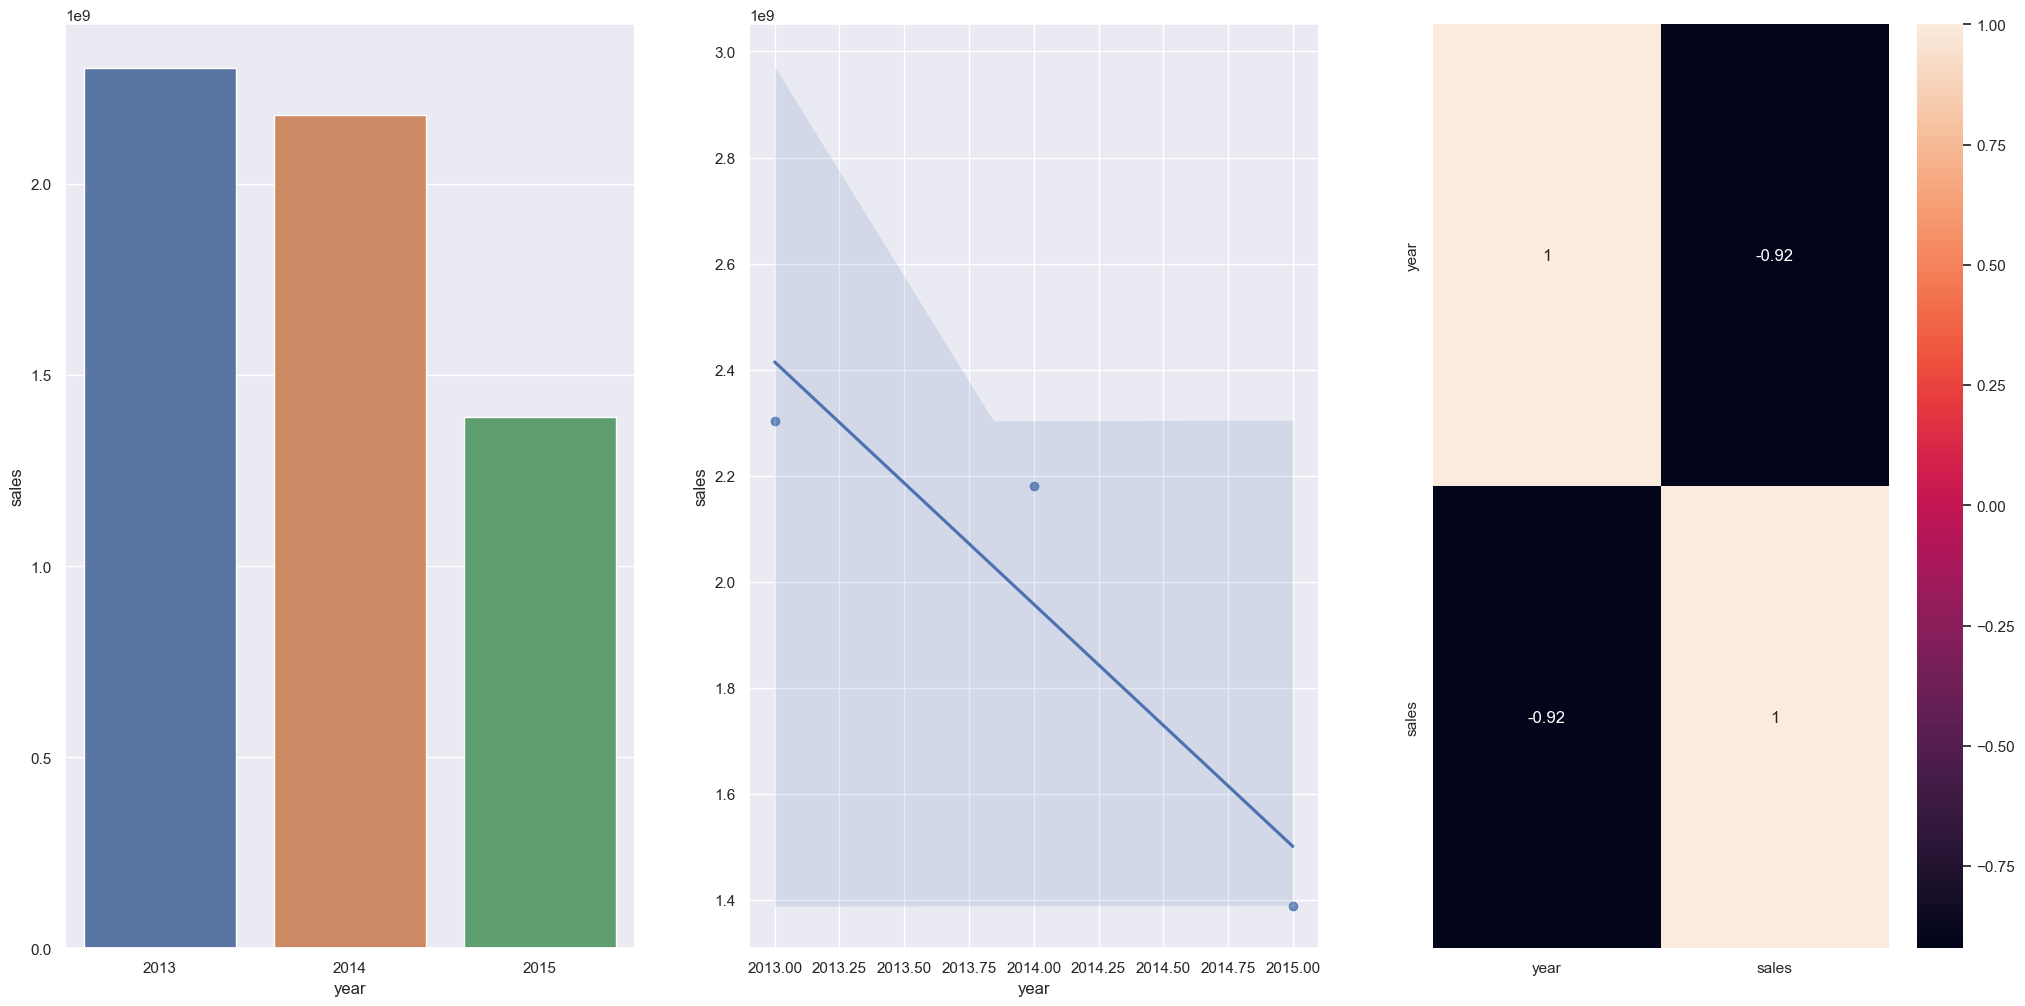

In [43]:
aux = df3.loc[:, ['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(data = aux, x='year', y='sales');

plt.subplot(1, 3, 2)
sns.regplot(data = aux, x='year', y='sales');

plt.subplot(1, 3, 3)
sns.heatmap(aux.corr(method='pearson'), annot=True);

#### H.8 Lojas deveriam vender mais no segundo semestre do ano
 - ***VERDADEIRA*** Lojas vendem MAIS no segundo semestre do ano

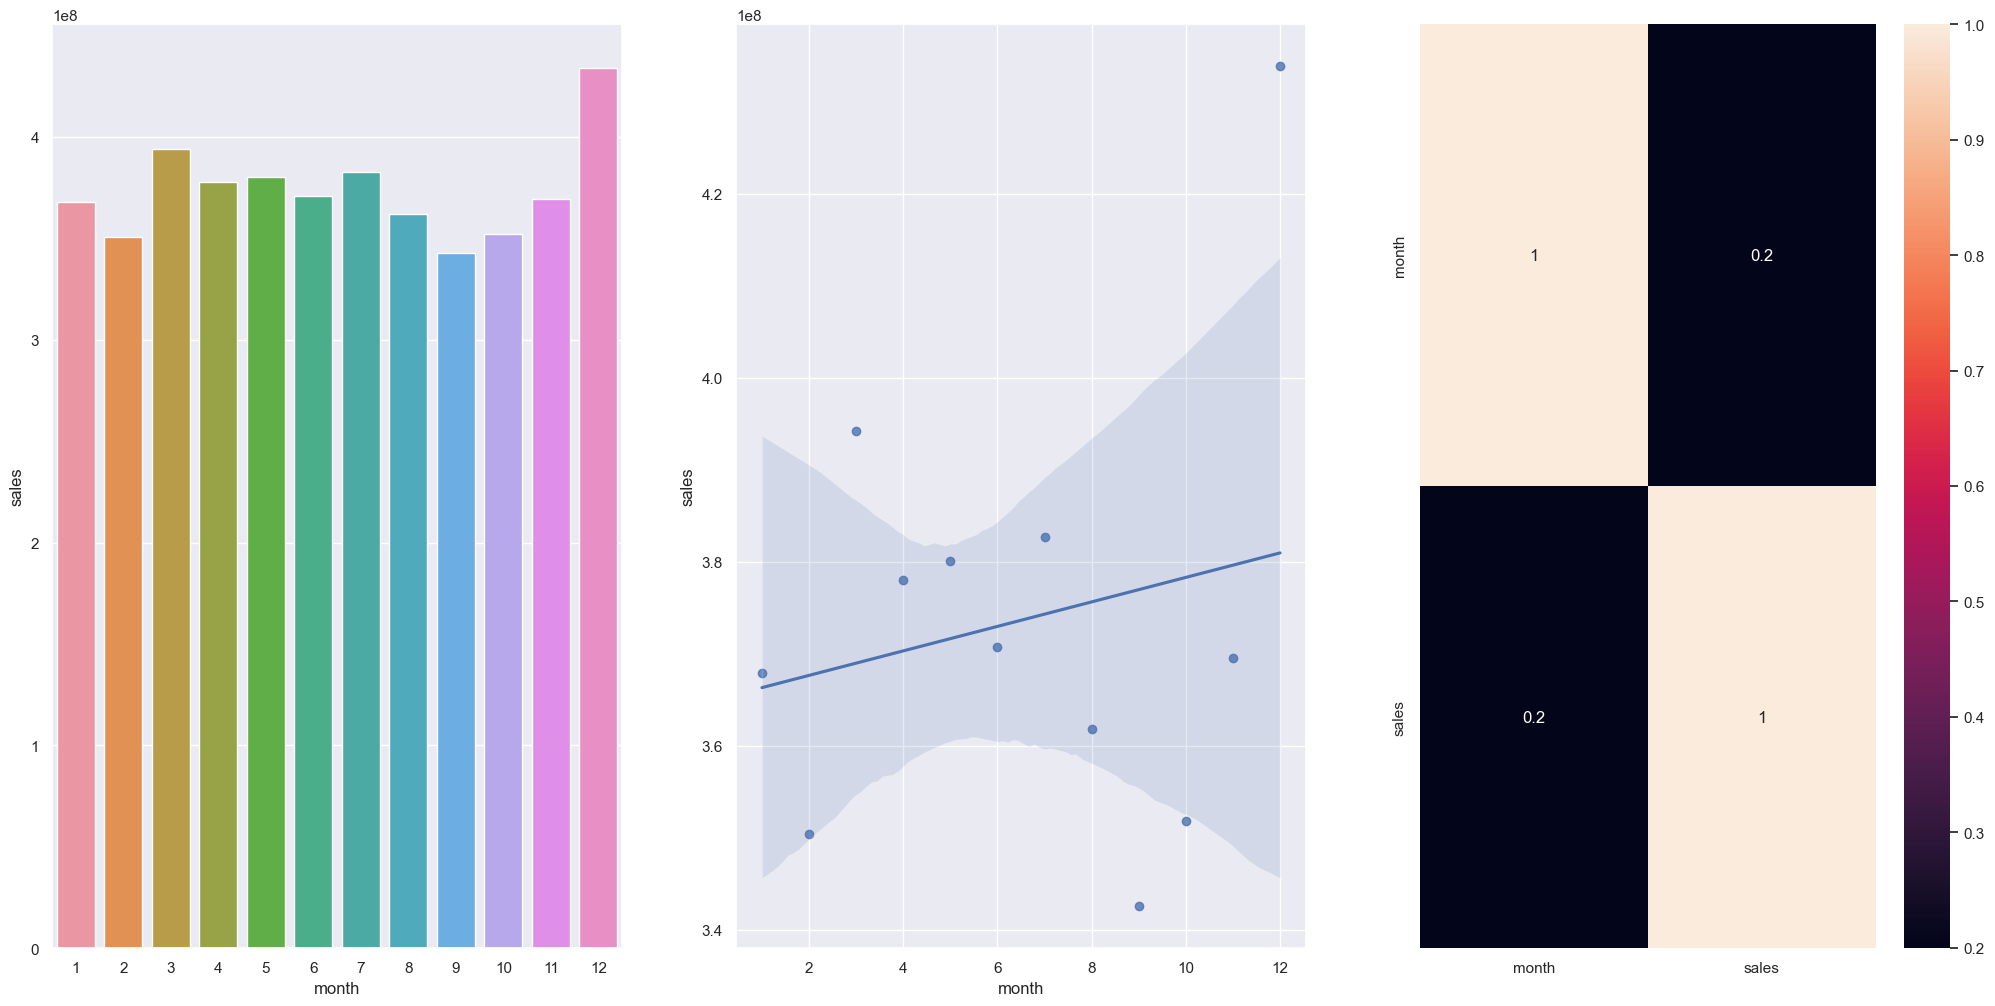

In [44]:
#desconsiderando 2015, pois os dados são INCOMPLETOS
aux = df3.loc[df3['year'] != 2015, ['month', 'sales']].groupby('month').sum().reset_index()

#groupby
aux = aux.loc[:, ['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(data = aux, x='month', y='sales');

plt.subplot(1, 3, 2)
sns.regplot(data = aux, x='month', y='sales');

plt.subplot(1, 3, 3)
sns.heatmap(aux.corr(method='pearson'), annot=True);

#### H.9 Lojas deveriam vender mais apos o dia 10 de cada mes
 - ***VERDADEIRA*** Lojas vendem MAIS apos o dia 10 de cada mes

<Axes: xlabel='before_after', ylabel='sales'>

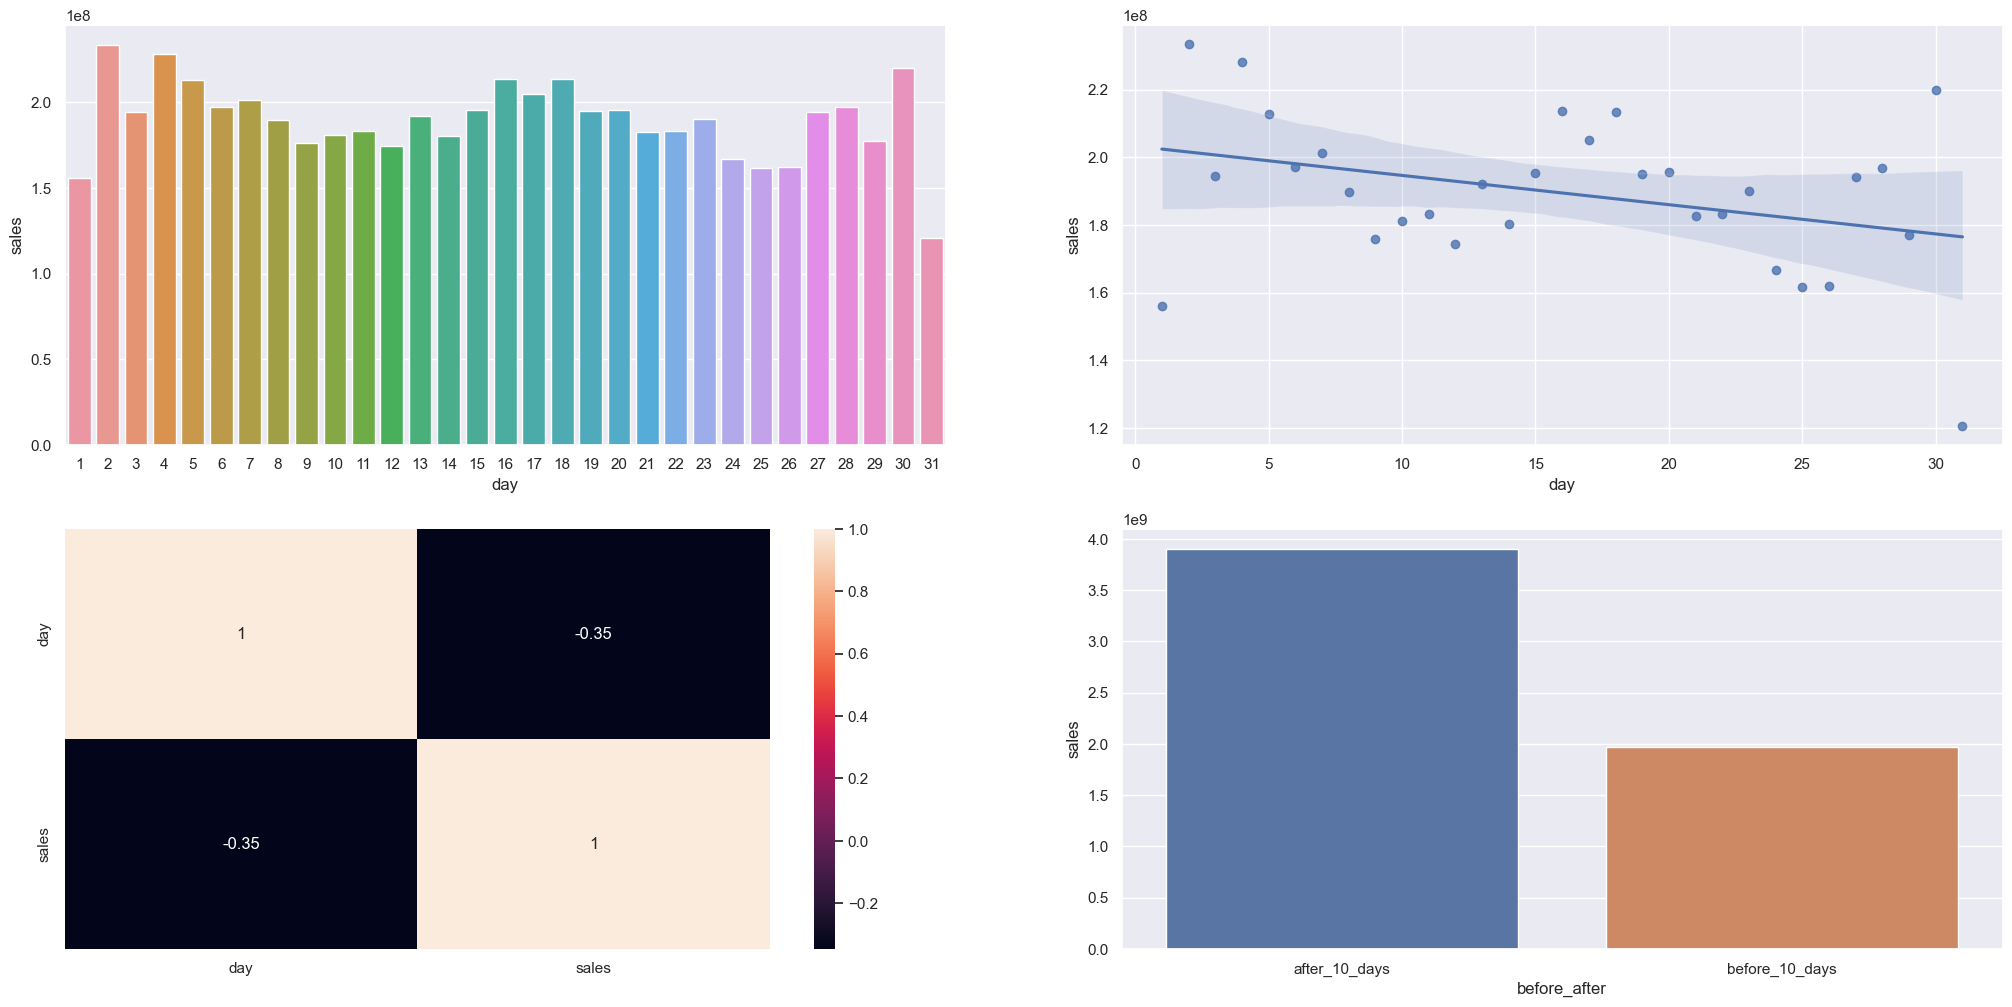

In [45]:
aux = df3.loc[:, ['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(data = aux, x='day', y='sales');

plt.subplot(2, 2, 2)
sns.regplot(data = aux, x='day', y='sales');

plt.subplot(2, 2, 3)
sns.heatmap(aux.corr(method='pearson'), annot=True);

#antes / depois dia 10
aux['before_after'] = aux['day'].apply(lambda x: 'before_10_days' if x <=10 else 'after_10_days')
before_after = aux.loc[:, ['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(data = before_after, x='before_after' , y='sales')

#### H10 Lojas deveriam vender menos aos finais de semana 
 - ***VERDADEIRA*** Lojas vendem menos aos finais de semana

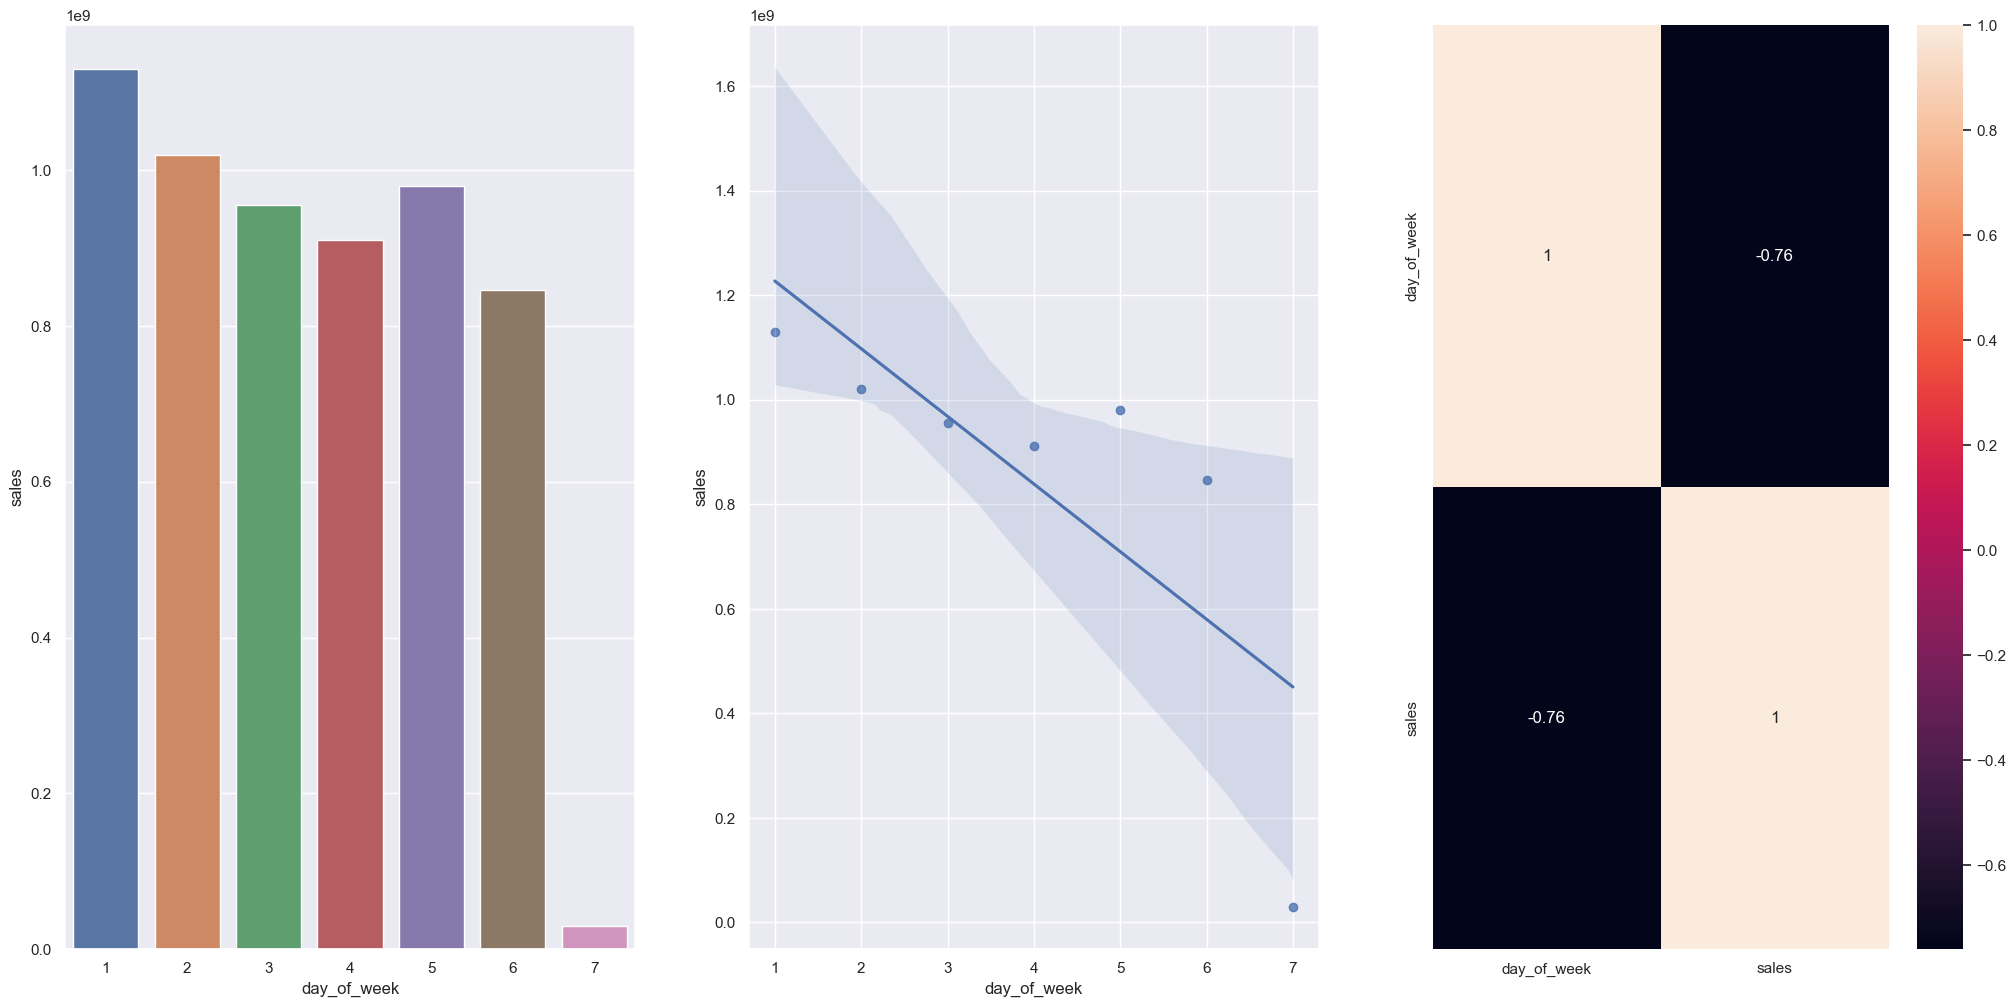

In [46]:
aux = df3.loc[:, ['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(data = aux, x='day_of_week', y='sales');

plt.subplot(1, 3, 2)
sns.regplot(data = aux, x='day_of_week', y='sales');

plt.subplot(1, 3, 3)
sns.heatmap(aux.corr(method='pearson'), annot=True);

#### H.11 Lojas deveriam vender menos durante feriados escolares
 - ***FALSA*** Lojas durante os feriados escolares VENDEM menos, **EXCETO** meses de julho e agosto 

<Axes: xlabel='month', ylabel='sales'>

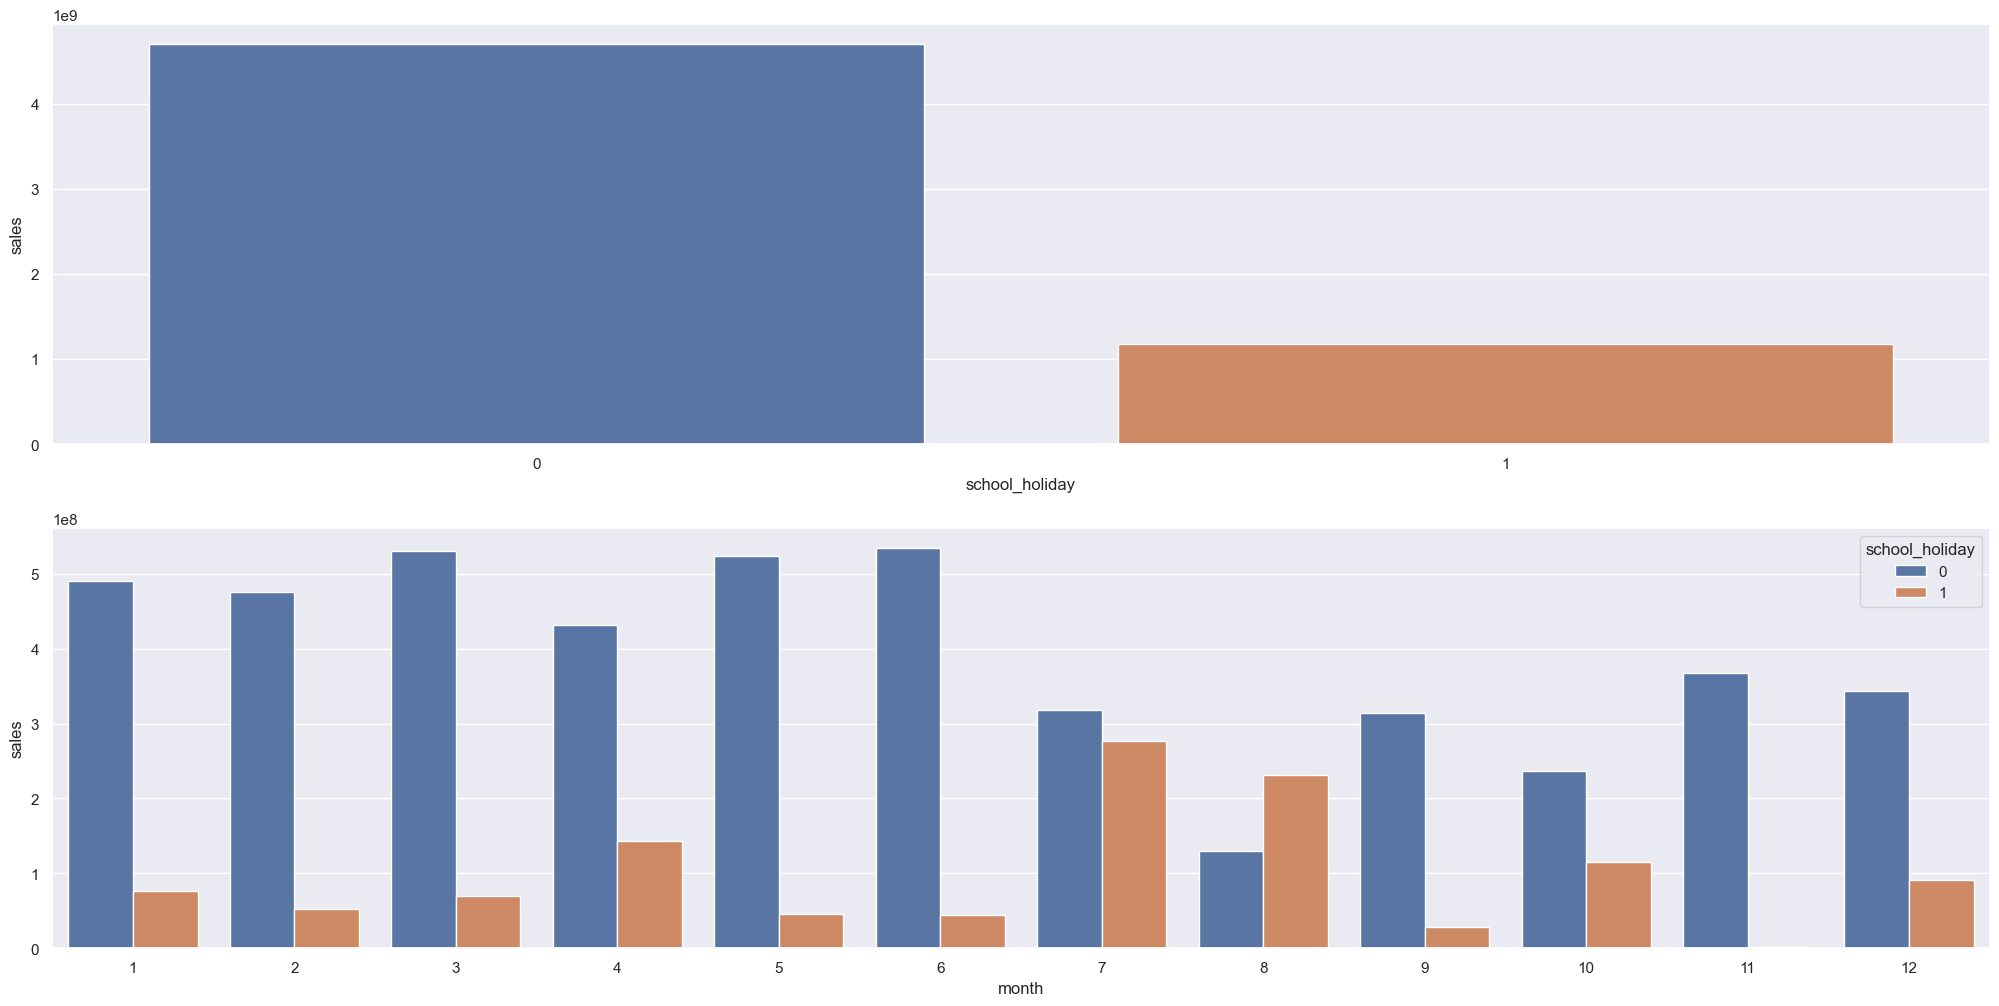

In [47]:
aux = df3.loc[:,['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2, 1, 1)
sns.barplot(data = aux, x='school_holiday' , y='sales')


plt.subplot(2, 1, 2)
aux1 = df3.loc[:,['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(data = aux1, x='month' , y='sales', hue='school_holiday')

### 11.3 Analise Multvariada

#### Numerical Attributes

<Axes: >

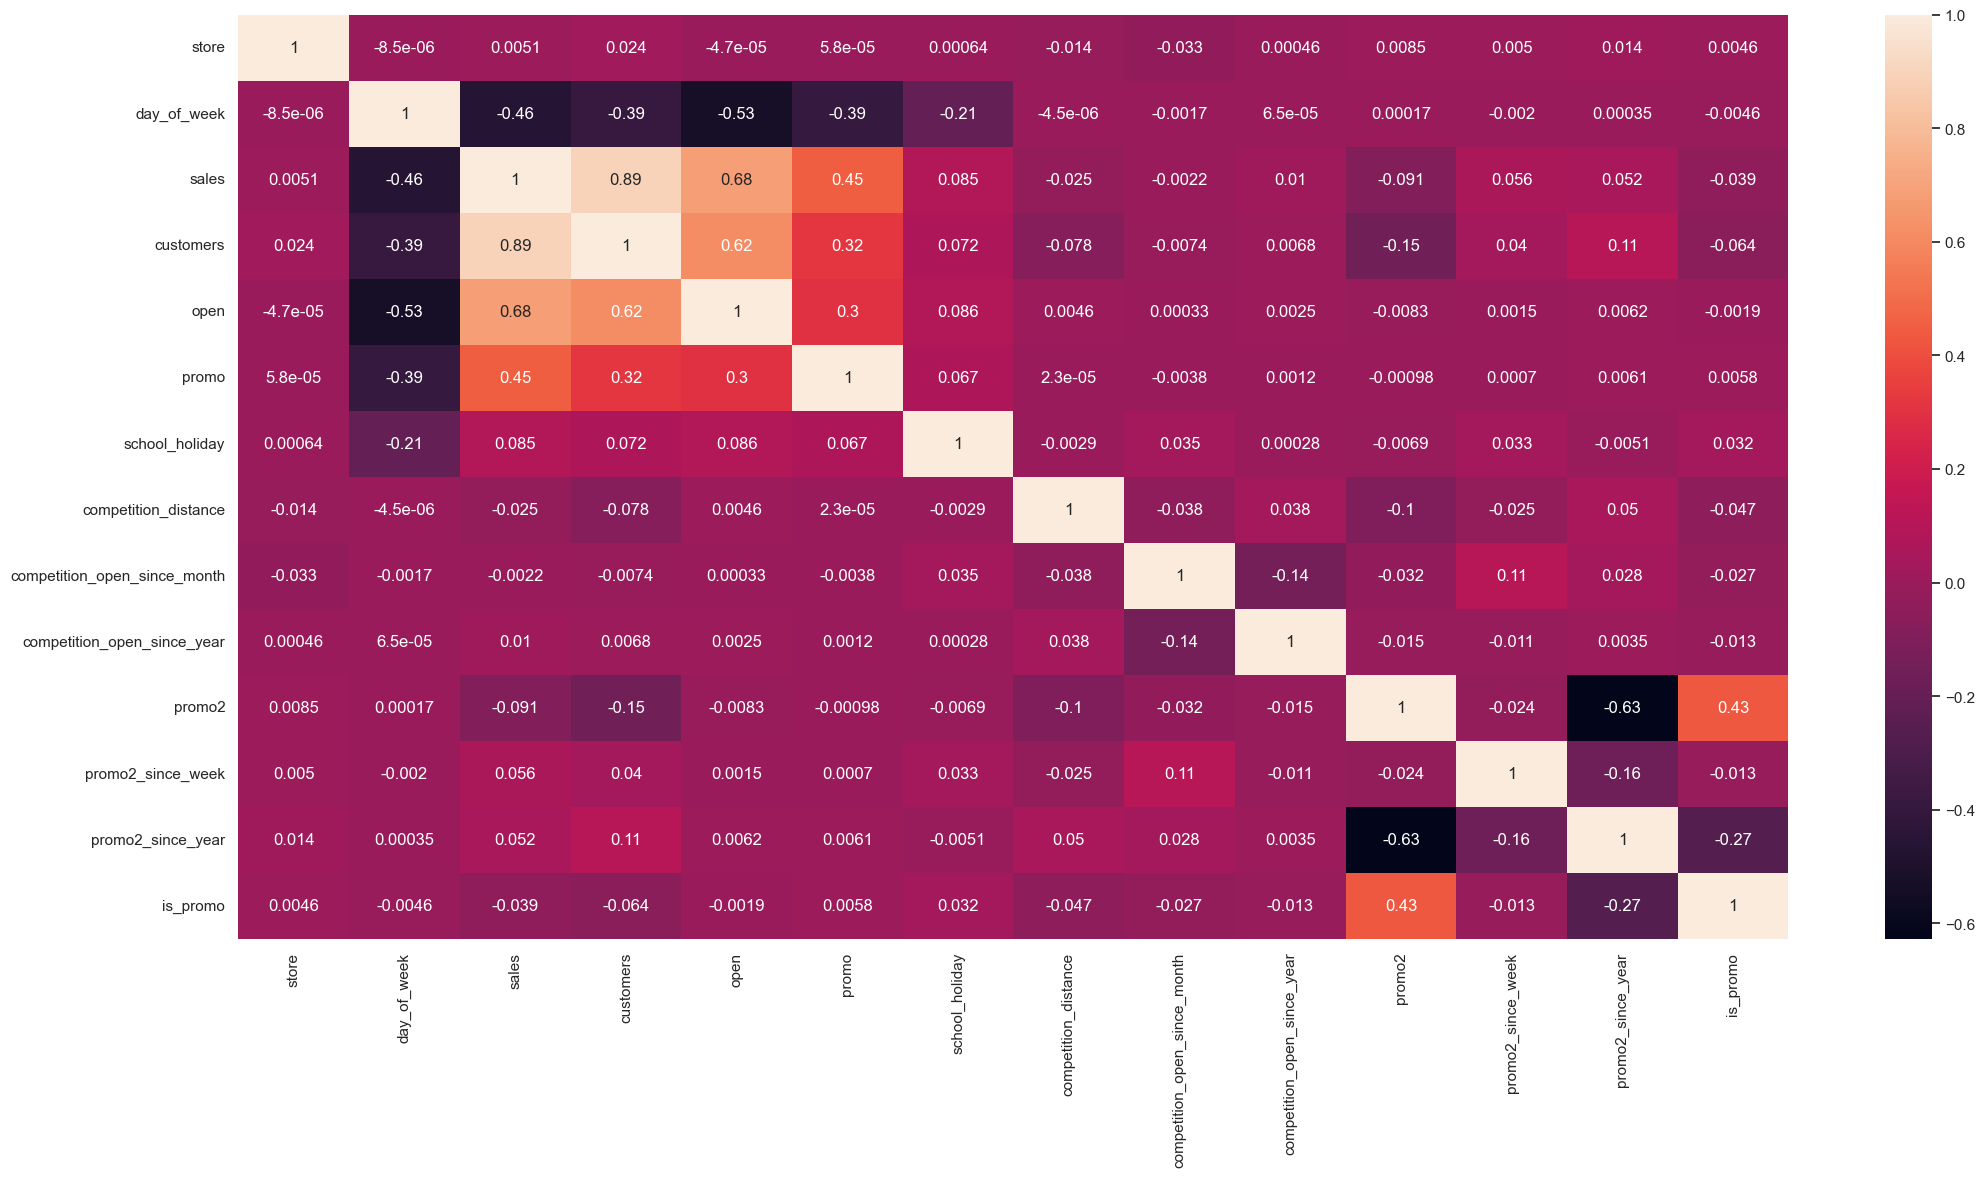

In [48]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

#### Categorical Attributes

In [49]:
a = df3.select_dtypes(include='object')

In [50]:
#apenas dados categoricos
a = df3.select_dtypes(include='object')

#calculando o cramer v
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#final dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)

<Axes: >

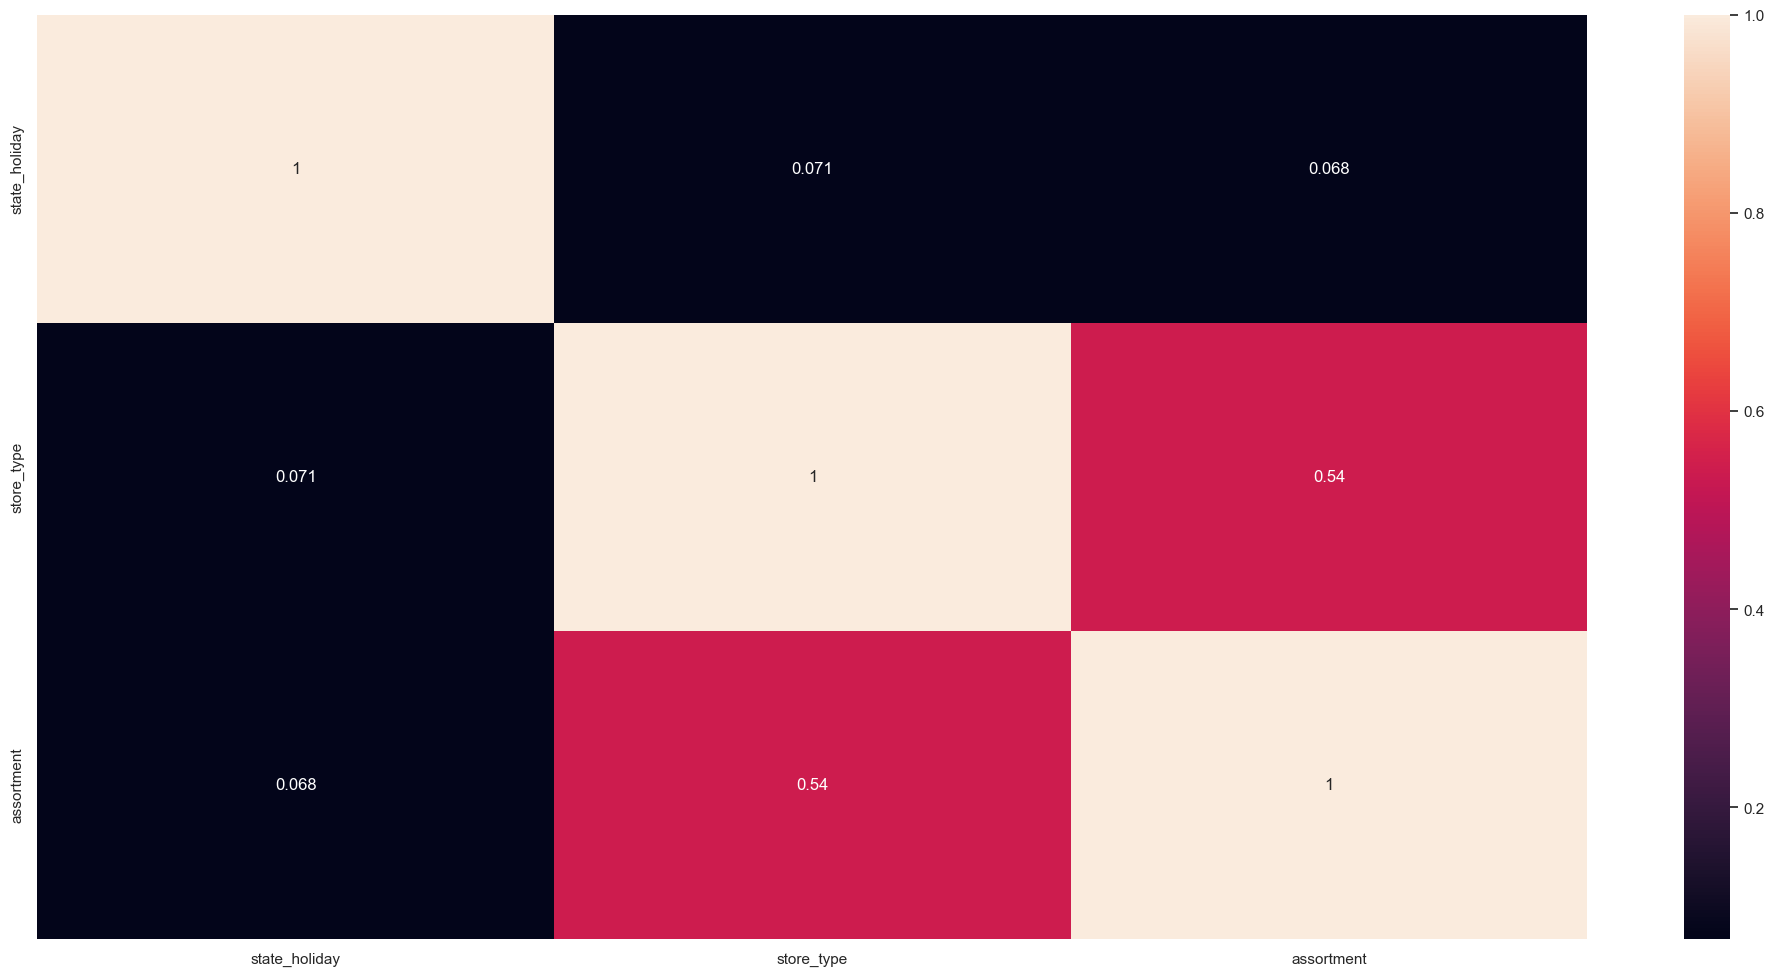

In [51]:
#quanto mais proximo de 1, melhor é a correlação
#melhor correlação -> store_type/assortment
sns.heatmap(d, annot=True)

# **4 PREPARAÇÃO DOS DADOS**

In [52]:
df4 = df3.copy()

In [53]:
a = df4.select_dtypes(exclude=['datetime64[ns]', 'object'])
a = a.agg(['min', 'max', 'ptp']).T.reset_index()
a.columns = ['colunas', 'minimo', 'maximo', 'range']
a

,colunas,minimo,maximo,range
0,store,1.0,1115.0,1114.0
1,day_of_week,1.0,7.0,6.0
2,sales,46.0,41551.0,41505.0
3,promo,0.0,1.0,1.0
4,school_holiday,0.0,1.0,1.0
5,competition_distance,20.0,200000.0,199980.0
6,competition_open_since_month,1.0,12.0,11.0
7,competition_open_since_year,1900.0,2015.0,115.0
8,promo2,0.0,1.0,1.0
9,promo2_since_week,1.0,52.0,51.0


## Normalização
  - rescala o centro para 0 com devio padrão igual a 1.

 - **X new = X - mean / std**
   - x new -> novo valor
   - x -> valor da linha
   - mean -> media
   - std -> desvio padrao

In [54]:
#NOMALIZAÇÃO NÃO APLICADA, POIS NÃO TINHA VARIAVEIS 'NORMAIS'

## Rescaling
  - rescala para o intervalo entre 0 e 1.

 - **X new = X - mean / X max - X min**
   - x new -> novo valor
   - x -> valor da linha
   - mean -> media
   - x max -> valor maximo
   - x min -> valor minimo 


Robust scaler - altera a performace do rescaling em variáis onde o **OUTLIER É MUITO FORTE**.

- **X new = x - Q1(x) / Q3(x) - Q1(x)**
  - x new -> novo valor
  - x -> valor inicial
  - q1 -> 1º quartil
  - q3 -> 3º quartil

<Axes: >

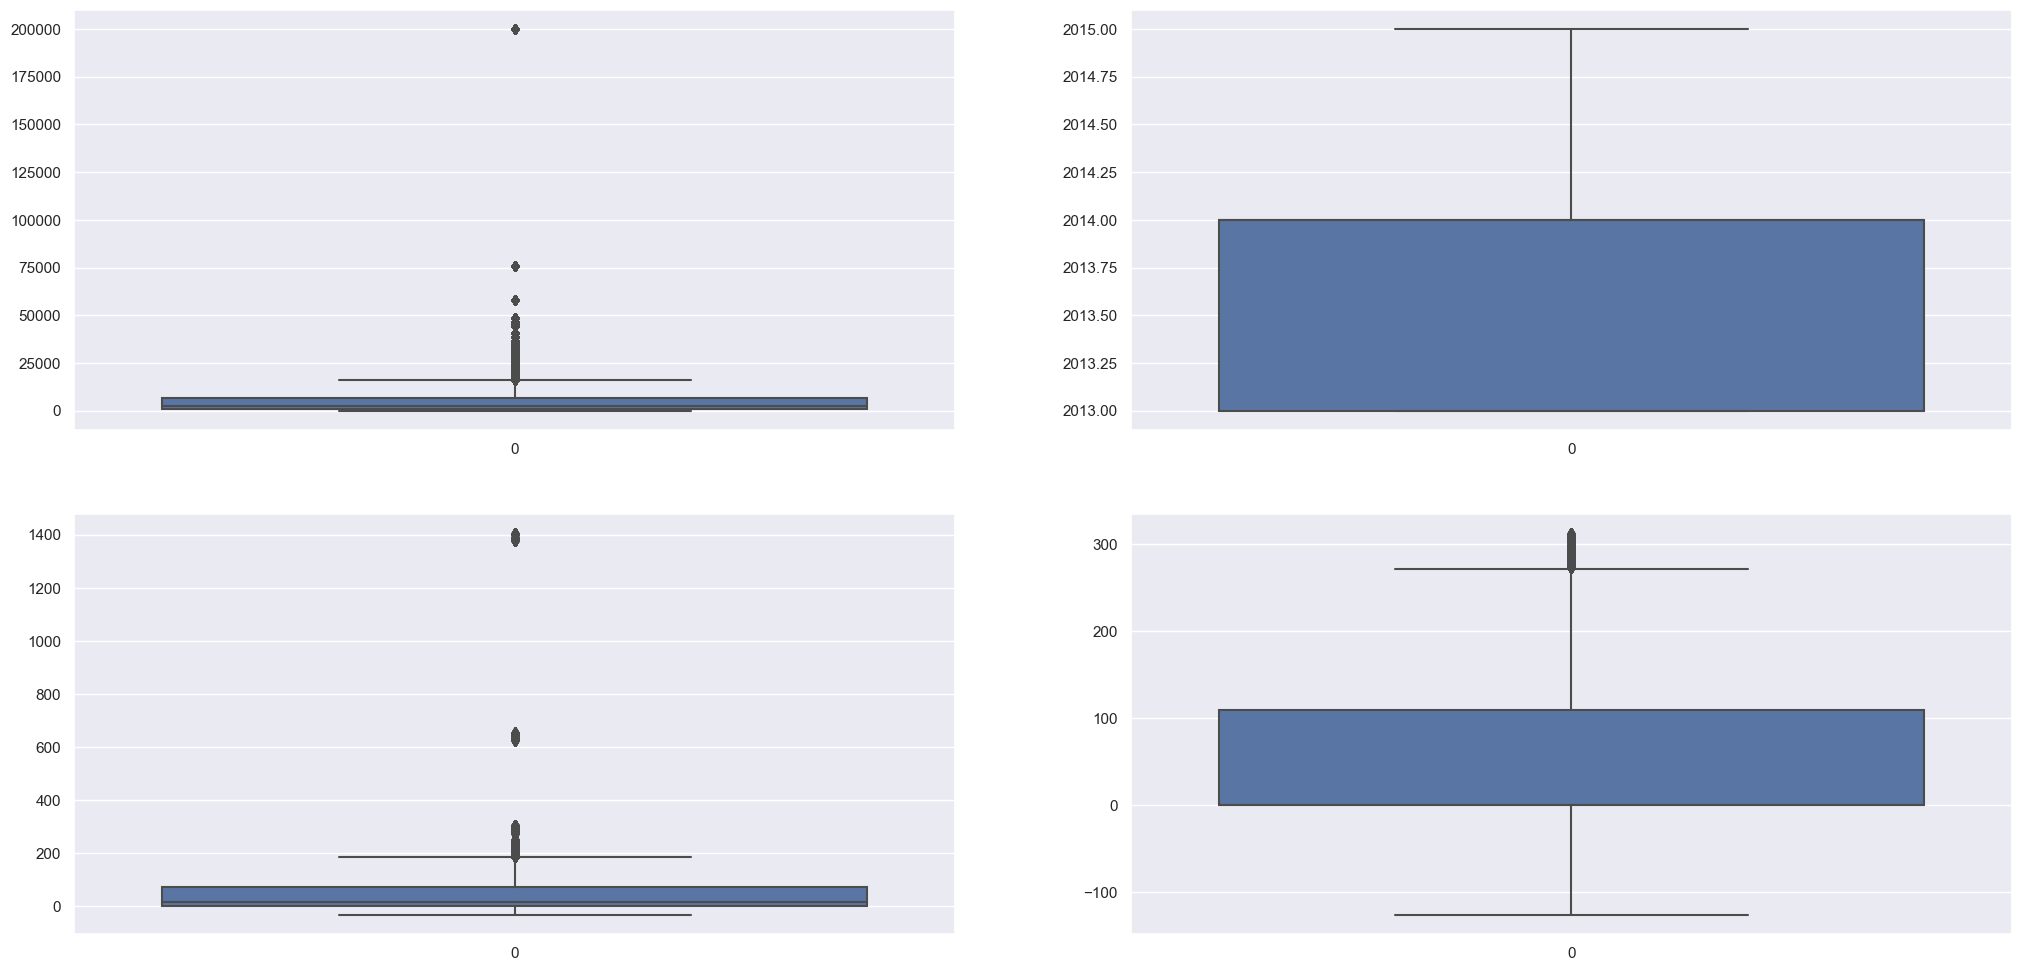

In [55]:
# VERIFICANDO A EXISTENCIA DE OUTLIER AGRESSIVOS PARAR APLICAR RESCALING OU ROBUST SCALER

# competition distance
plt.subplot(2, 2, 1)
sns.boxplot(df4['competition_distance'])

# year
plt.subplot(2, 2, 2)
sns.boxplot(df4['year'])

# competition time month
plt.subplot(2, 2, 3)
sns.boxplot(df4['competition_time_month'])

# promo time week
plt.subplot(2, 2, 4)
sns.boxplot(df4['promo_time_week'])

In [56]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df4['competition_distance'] = rs.fit_transform(df4[['competition_distance']].values)

# competition time month
df4['competition_time_month'] = rs.fit_transform(df4[['competition_time_month']].values)

# promo time week
df4['promo_time_week'] = mms.fit_transform(df4[['promo_time_week']].values)

#year
df4['year'] = mms.fit_transform(df4[['year']].values)


## Transformação
  - conversão de features categorica para numerica
  - transformação de natureza (meses do ano)

### Encoding

In [57]:
#state_holiday - ONE HOT ENCODING -> divide em novas colunas com nome das linhas unicas
df4 = pd.get_dummies(df4, prefix=['state_holiday'], columns=['state_holiday'])

#transformando booleanos em int
boolean_dict = {True: 1,
                False: 0}

df4['state_holiday_christmas'] = df4['state_holiday_christmas'].map(boolean_dict)
df4['state_holiday_easter_holiday'] = df4['state_holiday_easter_holiday'].map(boolean_dict)
df4['state_holiday_public_holiday'] = df4['state_holiday_public_holiday'].map(boolean_dict)
df4['state_holiday_regular_day'] = df4['state_holiday_regular_day'].map(boolean_dict)

#store_type - LABEL ENCODING -> tranforma coluna que antes era nome, em numero.
#utilizado nessa situação, pois não existe uma hierarquia na diferença desses dados (a , b, c, d)
le = LabelEncoder()
df4['store_type'] = le.fit_transform(df4['store_type'])

#assortment - ORDINAL ENCODING -> ordena por tamanho, necessario entendimento de negocio p/ passar um dicionario
assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended': 3}

df4['assortment'] = df4['assortment'].map(assortment_dict)

In [58]:
df4.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,30,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,30,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,30,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,30,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,30,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


### Response Variable Transformation

In [59]:
df4['sales'] = np.log1p(df4['sales'])

### Nuture Transformation

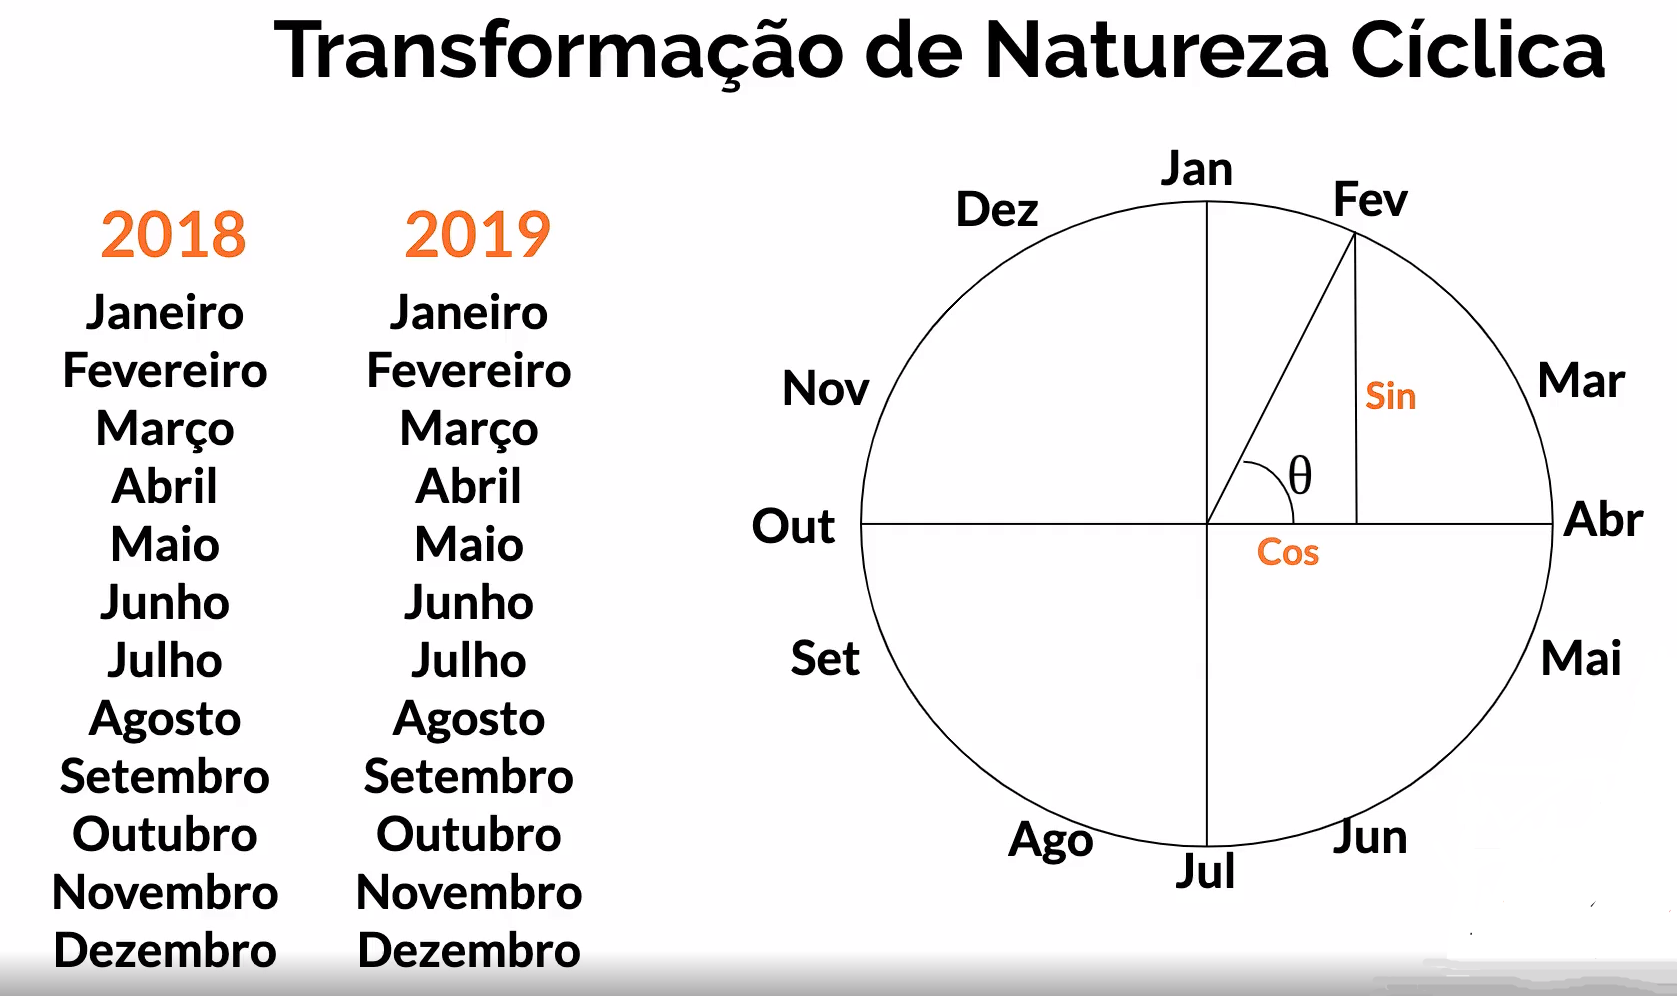

In [60]:
Image('img/nature_transformation.png')

In [61]:
#day o week
df4['day_of_week_sin'] = df4['day_of_week'].apply(lambda x: np.sin(x * ( 2. * np.pi/7) ) )
df4['day_of_week_cos'] = df4['day_of_week'].apply(lambda x: np.cos(x * ( 2. * np.pi/7) ) )

#month
df4['month_sin'] = df4['month'].apply(lambda x: np.sin(x * ( 2. * np.pi/12) ) )
df4['month_cos'] = df4['month'].apply(lambda x: np.cos(x * ( 2. * np.pi/12) ) )

#day
df4['day_sin'] = df4['day'].apply(lambda x: np.sin(x * ( 2. * np.pi/30) ) )
df4['day_cos'] = df4['day'].apply(lambda x: np.cos(x * ( 2. * np.pi/30) ) )

#week of year
df4['week_of_year_sin'] = df4['week_of_year'].apply(lambda x: np.sin(float(x) * ( 2. * np.pi/52) ) )
df4['week_of_year_cos'] = df4['week_of_year'].apply(lambda x: np.cos(float(x) * ( 2. * np.pi/52) ) )


# **5 FEATURE SELECTION**

In [62]:
df5 = df4.copy()

## Split dataframe into training and test dataset
Baseado nas métrica e entendimento do negócio, a conclusão mais acertiva para separar treino/teste foi a seguinte:

 - 1. dropar colunas que serviram apenas para criação de novas colunas.

 - 2. visto que o problema de negócio pede a previsão dos proximos 6 meses, será utilizado como teste os ultimos 6 meses de venda.
 
 - 3. será utilizado como treino, todas as datas antecedentes os ultimos 6 meses de venda

In [63]:
#removendo variaveis que serviram para criar features
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df5 = df5.drop(cols_drop, axis=1)

In [64]:
#visualizando qual data representa 6 semanas antes da ultima venda.
#datetime.timedelta(days=6 * 7) -> representa as 6 semanas que antecedem a ultima venda
df5[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6 * 7)

Timestamp('2015-06-19 00:00:00')

In [65]:
# training dataset
X_train = df5[df5['date'] < '2015-06-19']
Y_train = X_train['sales']

# test dataset
X_test = df5[df5['date'] >= '2015-06-19']
Y_test = X_test['sales']

print('Trainig min date: {}'.format(X_train['date'].min()))
print('Trainig max date: {}'.format(X_train['date'].max()))

print('\nTest min date: {}'.format(X_test['date'].min()))
print('Test max date: {}'.format(X_test['date'].max()))

Trainig min date: 2013-01-01 00:00:00
Trainig max date: 2015-06-18 00:00:00

Test min date: 2015-06-19 00:00:00
Test max date: 2015-07-31 00:00:00


## Boruta as Feature Selector
Utilizado o boruta para selecionar as features que serão mais importantes para o modelo de machine learning.
 - 1. criado nova var de x treino para o boruta, dropando 'date' e 'sales' e utilizando o .values para pegar apenas valores
 - 2. seguindo a ordem da x treino, foi criada uma nova var y treino, pegando apenas os valores e utilizando .ravel para transformar tudo em um vetor.


In [66]:
"""#training and test dataset for boruta
x_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = Y_train.values.ravel()

#define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

#define boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)"""

"#training and test dataset for boruta\nx_train_n = X_train.drop(['date', 'sales'], axis=1).values\ny_train_n = Y_train.values.ravel()\n\n#define RandomForestRegressor\nrf = RandomForestRegressor(n_jobs=-1)\n\n#define boruta\nboruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)"

### Best Feauture by Boruta
 - 1. transformando em lista o ranking criado pelo boruta (EX: 1-3ª, 2-10ª, 3-5ª...).
 - 2. nova var dropando colunas que não foram para o boruta.
 - 3. utilizando nova var para localizar nome das colunas raqueadas.
 - 4. utilizando o ***np.setdiff1d*** para localizar dados presentes em apenas uma var

In [67]:
"""#selecionando variaveis ranqueadas por relevancia
cols_selected = boruta.support_.tolist()

#melhores colunas
x_train_fs = X_train.drop(['date', 'sales'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

#colunas excluidas
not_selected_boruta = np.setdiff1d(x_train_fs.columns, cols_selected_boruta)"""

"#selecionando variaveis ranqueadas por relevancia\ncols_selected = boruta.support_.tolist()\n\n#melhores colunas\nx_train_fs = X_train.drop(['date', 'sales'], axis=1)\ncols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()\n\n#colunas excluidas\nnot_selected_boruta = np.setdiff1d(x_train_fs.columns, cols_selected_boruta)"

In [68]:
"""cols_selected_boruta"""

'cols_selected_boruta'

In [69]:
"""not_selected_boruta"""

'not_selected_boruta'

### Manual Feature Selection
 - Adicionando manualmente as colunas importante para o boruta, para não roda-lo novamente.
 - adicionando o month_sin, pois o modelo considerou o month_cos como importante.

In [70]:
cols_selected_boruta = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin']

# Columns to add
feat_to_add = ['date', 'sales']

#variavel que recebe colunas do boruta + date e sales
#PS: modelos não conseguem performar com data e o sales
cols_select_full = cols_selected_boruta.copy()

# Final features
cols_select_full.extend(feat_to_add)

# **6 MACHINE LEARNING**

In [71]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

#time series data preparation
x_training = X_train[cols_select_full]

X_train(Upper) - todos os dados (date/sales)

x_train(Lower) - apenas os relevantes para o modelo

## Average Model

In [72]:
"""# x_test/train - data set compelto
# y_test/train - valor de sales

#copiando o dataframe para uma var
aux1 = x_test.copy()
#criando new coluna com os valores de sales test
aux1['sales'] = y_test.copy()

#predicition
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
#mesclando 2 dfs pelo id da loja, para obter coluna de sales e predição da mesma
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#performace
#voltando p/ sales originais utilizando exponecial(np.expm1), o oposto do log utilizado no encoding.
#aplicando função
baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result"""

"# x_test/train - data set compelto\n# y_test/train - valor de sales\n\n#copiando o dataframe para uma var\naux1 = x_test.copy()\n#criando new coluna com os valores de sales test\naux1['sales'] = y_test.copy()\n\n#predicition\naux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})\n#mesclando 2 dfs pelo id da loja, para obter coluna de sales e predição da mesma\naux1 = pd.merge(aux1, aux2, how='left', on='store')\nyhat_baseline = aux1['predictions']\n\n#performace\n#voltando p/ sales originais utilizando exponecial(np.expm1), o oposto do log utilizado no encoding.\n#aplicando função\nbaseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1(yhat_baseline))\nbaseline_result"

Entendimento: Foi feito uma groupby() pegando a média de cada loja e mesclando essa media em uma nova coluna do dataset, sendo assim... cada loja recebeu a média de todas as suas vendas. Ao fim, foi feito uma analise de performace com todos os erros (MAE, MAPE, RMSE).

## Linear Regression

In [73]:
"""#model
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performace
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result"""

"#model\nlr = LinearRegression().fit(x_train, y_train)\n\n#prediction\nyhat_lr = lr.predict(x_test)\n\n#performace\nlr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))\nlr_result"

## Linear Regression Regularized - LASSO

In [74]:
"""#model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

#prediction
yhat_lrr = lr.predict(x_test)

#performace
lrr_result = ml_error('Linear Regression - LASSO', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result"""

"#model\nlrr = Lasso(alpha=0.01).fit(x_train, y_train)\n\n#prediction\nyhat_lrr = lr.predict(x_test)\n\n#performace\nlrr_result = ml_error('Linear Regression - LASSO', np.expm1(y_test), np.expm1(yhat_lrr))\nlrr_result"

O erro **RMSE** do linear é maior do que average model, oq significa que:
   1. modelo de media é melhor do que o linear;
   2. os dados tem um comportamento complexo, não linear. sendo assim, modelos lineares não performam bem.

## Random Forest Regressor

In [75]:
"""#model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performace
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result"""

"#model\nrf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)\n\n#prediction\nyhat_rf = rf.predict(x_test)\n\n#performace\nrf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))\nrf_result"

## XGboost Regressor

In [76]:
"""#model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                             n_estimators = 3000,
                             eta = 0.03,
                             max_depth = 10,
                             subsample = 0.7,
                             min_child_weight = 3,
                             colsample_bytree = 0.7).fit(x_train, y_train)

#prediction
yhat_xgb = model_xgb.predict(x_test)

#performace
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result"""

"#model\nmodel_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',\n                             n_estimators = 3000,\n                             eta = 0.03,\n                             max_depth = 10,\n                             subsample = 0.7,\n                             min_child_weight = 3,\n                             colsample_bytree = 0.7).fit(x_train, y_train)\n\n#prediction\nyhat_xgb = model_xgb.predict(x_test)\n\n#performace\nxgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))\nxgb_result"

## Comparando Modelos

In [77]:
#model_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])

#dicionario para não rodar novamente todos os modelos
model_result = {'Model Name': ['Average Model',
                'Linear Regression',
                'Linear Regression - LASSO',
                'Random Forest Regressor',
                'XGBoost Regressor'],
                'MAE': [1354.8003525745382,
                1867.2717635569777,
                1867.2717635569777,
                666.2548756305843,
                623.7749110339909],
                'MAPE': [0.20640038121581475,
                0.29264409322541285,
                0.29264409322541285,
                0.09746614391265494,
                0.0900811645814886],
                'RMSE': [1835.1355423287778,
                2671.581530160912,
                2671.581530160912,
                994.4414743954437,
                910.9107894555455]}


model_result = pd.DataFrame(model_result)
model_result.sort_values('RMSE')
#model_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
4,XGBoost Regressor,623.774911,0.090081,910.910789
3,Random Forest Regressor,666.254876,0.097466,994.441474
0,Average Model,1354.800353,0.206400,1835.135542
1,Linear Regression,1867.271764,0.292644,2671.581530
2,Linear Regression - LASSO,1867.271764,0.292644,2671.581530


## Cross-Validation

In [78]:
# var de treino com todas as colunas do data set
x_training = X_train[cols_select_full]

### Linear Regression 

In [79]:
'''model = LinearRegression()
lr_result = cross_validation(x_training, 5, 'Linear Regression', model, verbose=True)
lr_result'''

"model = LinearRegression()\nlr_result = cross_validation(x_training, 5, 'Linear Regression', model, verbose=True)\nlr_result"

### Linear Regression - Lasso

In [80]:
'''model = Lasso(alpha=0.01)
lrr_result = cross_validation(x_training, 5, 'Lasso', model, verbose=True)
lrr_result'''

"model = Lasso(alpha=0.01)\nlrr_result = cross_validation(x_training, 5, 'Lasso', model, verbose=True)\nlrr_result"

### Random Forest Regression

In [81]:
'''model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)
rf_result = cross_validation(x_training, 5, 'Random Forest Regressor', model, verbose=True)
rf_result'''

"model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)\nrf_result = cross_validation(x_training, 5, 'Random Forest Regressor', model, verbose=True)\nrf_result"

### XGBoost Regressor

In [82]:
'''model = xgb.XGBRegressor(objective = 'reg:squarederror',
                             n_estimators = 3000,
                             eta = 0.03,
                             max_depth = 10,
                             subsample = 0.7,
                             min_child_weight = 3,
                             colsample_bytree = 0.7).fit(x_train, y_train)

xgb_result = cross_validation(x_training, 5, 'XGBoost', model, verbose=True)
xgb_result'''

"model = xgb.XGBRegressor(objective = 'reg:squarederror',\n                             n_estimators = 3000,\n                             eta = 0.03,\n                             max_depth = 10,\n                             subsample = 0.7,\n                             min_child_weight = 3,\n                             colsample_bytree = 0.7).fit(x_train, y_train)\n\nxgb_result = cross_validation(x_training, 5, 'XGBoost', model, verbose=True)\nxgb_result"

### Comparando Performace Modelo

In [83]:
#modeling_result = pd.concat([lr_result, lrr_result, rf_result, xgb_result])

#adicionado resultado a mão, para não rodar o codigo novamente
modeling_result = {'Model Name': ['Linear Regression',
                    'Lasso',
                    'Random Forest Regressor',
                    'XGBoost'],
                    'MAE CV': ['2081.29 +/- 294.74',
                    '2116.61 +/- 341.53',
                    '835.74 +/- 222.44',
                    '788.86 +/- 125.87'],
                    'MAPE CV': ['0.3 +/- 0.02',
                    '0.29 +/- 0.01',
                    '0.12 +/- 0.02',
                    '0.11 +/- 0.01'],
                    'RMSE CV': ['2951.89 +/- 466.99',
                    '3057.87 +/- 504.64',
                    '1259.18 +/- 327.02',
                    '1147.33 +/- 190.72']}

modeling_result = pd.DataFrame(modeling_result)
modeling_result.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
3,XGBoost,788.86 +/- 125.87,0.11 +/- 0.01,1147.33 +/- 190.72
2,Random Forest Regressor,835.74 +/- 222.44,0.12 +/- 0.02,1259.18 +/- 327.02
0,Linear Regression,2081.29 +/- 294.74,0.3 +/- 0.02,2951.89 +/- 466.99
1,Lasso,2116.61 +/- 341.53,0.29 +/- 0.01,3057.87 +/- 504.64


# **7 HYPERPARAMETER FINE TUNNING**

## Random Search

In [86]:
import random

In [90]:
param = {
        'n_estimators': [15, 17, 25, 30, 35],
         'eta': [0.01, 0.03],
         'max_depth': [3, 5, 9],
         'subsample': [0.1, 0.5, 0.7],
         'min_child_weight': [3, 8, 15],
         'colsample_bytree': [3, 8, 15]
         }

MAX_EVAL = 2

In [92]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    #escolhendo valores do parametro aleatoriamente
    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
    print(hp)

    #model
    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                                n_estimators = hp['n_estimators'],
                                eta = hp['eta'],
                                max_depth = hp['max_depth'],
                                subsample = hp['subsample'],
                                min_child_weight = hp['min_child_weight'],
                                colsample_bytree = hp['colsample_bytree'])

    #performace
    result = cross_validation(x_training, 2, 'XGBoost', model_xgb, verbose=True)
    final_result = pd.concat([final_result, result])

final_result  

{'n_estimators': 30, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'min_child_weight': 15, 'colsample_bytree': 15}

Kfold Number: 5


XGBoostError: value 15 for Parameter colsample_bytree exceed bound [0,1]
colsample_bytree: Subsample ratio of columns, resample on each tree construction.

## Final Model